# Deep Dive Analysis Template

In [1]:
%load_ext autoreload
%autoreload 2

In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import plotly.express as px
import plotly.graph_objects as go
from PIL import Image
import matplotlib as mpl
from scipy import stats
from plotly.subplots import make_subplots
# import psycopg
from datetime import datetime, timedelta
from sqlalchemy import create_engine, text
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import plotly.io as pio

# Set default Plotly template
pio.templates.default = "plotly_white"

# Silence deprecation warnings
import warnings

# Modules
from research_lab.utils.database import get_data_from_rds, get_df_time, get_engine, get_mp_confidence
from research_lab.utils.analysis import make_true_price_weight_index, make_equal_weight_index_smoothed_2, plot_index_enhanced, plot_indices_plotly
from research_lab.utils.vintage_year_scores import add_vintage_year_scores
from research_lab.utils.config import COLOURS, VINTAGE_MIN, LABEL_MEAN_PRICE_MIN

warnings.filterwarnings('ignore', category=DeprecationWarning)
warnings.filterwarnings('ignore', category=FutureWarning)

In [4]:
engine = get_engine()
watermark_path = "research_lab/images/watermark500x500.png"

In [15]:
main_purple = COLOURS['cool_purple']
colours = [colour for name, colour in COLOURS.items() if name != 'main_purple']

# To be used in plot titles 
REPORT_NAME = 'Burgundy II'

# Unsomment to cusomeise
# VINTAGE_MIN = 1975
# LABEL_MEAN_PRICE_MIN = 720

### Define df_info

In [ ]:
query = f"""

SELECT * 
FROM wine_static 
WHERE producer = 'Domaine de la Romanée-Conti'
"""

df_info = get_data_from_rds(engine,query)
print(df_info.shape)
df_info.head()

print(df_info.shape)

# Group by lwin7 to calculate label mean price
label_mean_prices = df_info.groupby('lwin7')['current_price'].mean()

# Filter out lwin7s with mean price below 720
high_value_lwin7s = label_mean_prices[label_mean_prices >= LABEL_MEAN_PRICE_MIN].index

# Filter the dataframe to only include wines from these high-value labels
df_info = df_info[df_info['lwin7'].isin(high_value_lwin7s)].copy()
print(df_info.shape)

(46460, 23)
(46460, 23)
(40040, 23)


In [17]:
# Basic filtering
df_info = df_info[(df_info['vintage'] == 1000) | (df_info['vintage'] > VINTAGE_MIN)].copy()

In [18]:
# Define lwin11s for df_time
lwin11_list = df_info['lwin11'].unique()
lwin11_str = "', '".join(lwin11_list)

### Define df_time

In [19]:
query = f""" 
    SELECT lwin11, price_clean, date
    FROM combined_prices
    WHERE lwin11 IN ('{lwin11_str}')
    """
# engine = get_engine()
df_time = get_df_time(engine, query)
print(df_time.shape)
df_time.head()

(281, 39030)


lwin11      10178291986  10178291994  10178291995  10178291996  10178291997  \
date                                                                          
2002-08-31          NaN          NaN          NaN          NaN          NaN   
2002-09-30          NaN          NaN          NaN          NaN          NaN   
2002-10-31          NaN          NaN          NaN          NaN          NaN   
2002-11-30          NaN          NaN          NaN          NaN          NaN   
2002-12-31          NaN          NaN          NaN          NaN          NaN   

lwin11      10178291999  10178292000  10178292001  10178292002  10178292003  \
date                                                                          
2002-08-31          NaN          NaN          NaN          NaN          NaN   
2002-09-30          NaN          NaN          NaN          NaN          NaN   
2002-10-31          NaN          NaN          NaN          NaN          NaN   
2002-11-30          NaN          NaN          NaN          NaN          NaN   
2002-12-31          NaN          NaN          NaN          NaN          NaN   

lwin11      ...  30411692022  30448382022  30475812022  30559282021  \
date        ...                                                       
2002-08-31  ...          NaN          NaN          NaN          NaN   
2002-09-30  ...          NaN          NaN          NaN          NaN   
2002-10-31  ...          NaN          NaN          NaN          NaN   
2002-11-30  ...          NaN          NaN          NaN          NaN   
2002-12-31  ...          NaN          NaN          NaN          NaN   

lwin11      30604072022  30642742023  30645352023  30653142022  30682142022  \
date                                                                          
2002-08-31          NaN          NaN          NaN          NaN          NaN   
2002-09-30          NaN          NaN          NaN          NaN          NaN   
2002-10-31          NaN          NaN          NaN          NaN          NaN   
2002-11-30          NaN          NaN          NaN          NaN          NaN   
2002-12-31          NaN          NaN          NaN          NaN          NaN   

lwin11      30683862022  
date                     
2002-08-31          NaN  
2002-09-30          NaN  
2002-10-31          NaN  
2002-11-30          NaN  
2002-12-31          NaN  

[5 rows x 39030 columns]

In [23]:
df_time.to_pickle('research_lab/projects/2025-12-12_drc_collection/data/df_time_current.pkl')

### Run analysis

**Add various columns required for analysis:**
- first_price_date
- first_price 
- lifetime_cagr
- 5yr_cagr
- 7yr_cagr 

In [ ]:
df_info['first_price_date'] = pd.NaT  # Use NaT (Not a Time) for datetime columns
df_info['first_price'] = np.nan

# Loop through each wine (lwin11) in df_info
for lwin in df_info['lwin11']:
    if lwin in df_time.columns:
        # Get the non-null prices for this wine
        non_null_prices = df_time[lwin].first_valid_index()
        
        if non_null_prices is not None:
            # Get the first price date and the first price
            first_price_date = non_null_prices
            first_price = df_time.loc[first_price_date, lwin]
            
            # Assign the values to df_info
            mask = df_info['lwin11'] == lwin
            df_info.loc[mask, 'first_price_date'] = first_price_date
            df_info.loc[mask, 'first_price'] = first_price

# Ensure first_price_date is in datetime format (redundant now but kept for clarity)
df_info['first_price_date'] = pd.to_datetime(df_info['first_price_date'])

In [ ]:
def get_last_day_of_previous_month(date):
    """Get the last day of the month preceding the given date."""
    first_day_current_month = date.replace(day=1)
    last_day_previous_month = first_day_current_month - timedelta(days=1)
    return last_day_previous_month

def calculate_cagr(start_price, end_price, years):
    """Calculate Compound Annual Growth Rate."""
    if pd.isna(start_price) or pd.isna(end_price) or start_price <= 0:
        return np.nan
    return ((end_price / start_price) ** (1 / years)) - 1

def process_info_data(df_info, df_time):
    """
    Process wine data to calculate absolute returns, lifetime CAGR, 7-year CAGR, 5-year CAGR, and 10-year CAGR.
    Also extracts the first price date and first price for each wine from df_time.

    df_info needs to have df_info['lwin11'], df_info['current_price'].
    
    df_time is indexed by date, and each column is a wine with prices over time.

    Returns:
    - df_info with additional columns: 'absolute_returns', 'lifetime_cagr', 'first_price_date',
      '7yr_cagr', '5yr_cagr', '10yr_cagr'.
    """
    df_info['lwin11'] = df_info['lwin11'].astype(str)
    # Ensure 'first_price_date' is in datetime format
    df_info['first_price_date'] = pd.to_datetime(df_info['first_price_date'])

    # Calculate absolute returns
    df_info['absolute_returns'] = df_info['current_price'] - df_info['first_price']

    # Use current date
    current_date = datetime.now()
    
    # Get the last day of the previous month
    last_day_previous_month = get_last_day_of_previous_month(current_date)
    last_day_previous_month_str = last_day_previous_month.strftime('%Y-%m-%d')
    
    # Calculate years from first price date to current date
    df_info['years_to_current'] = (current_date - df_info['first_price_date']).dt.days / 365.25

    # Calculate lifetime CAGR
    df_info['lifetime_cagr'] = np.NaN
    mask = df_info['years_to_current'] >= 1
    df_info.loc[mask, 'lifetime_cagr'] = ((df_info.loc[mask, 'current_price'] / df_info.loc[mask, 'first_price']) ** (1 / df_info.loc[mask, 'years_to_current'])) - 1

    # Dynamically calculate the reference dates
    # Handle leap years correctly by using date arithmetic instead of string replacement
    dates = {}
    
    # Check if dates exist in df_time index before assigning
    # Try to find the closest available date for each time period
    
    # For 10-year lookback
    target_10yr = (last_day_previous_month.replace(year=last_day_previous_month.year - 10) if 
                  last_day_previous_month.month != 2 or last_day_previous_month.day < 29 else
                  get_last_day_of_previous_month(datetime(last_day_previous_month.year - 10, 3, 1)))
    
    # For 7-year lookback
    target_7yr = (last_day_previous_month.replace(year=last_day_previous_month.year - 7) if 
                 last_day_previous_month.month != 2 or last_day_previous_month.day < 29 else
                 get_last_day_of_previous_month(datetime(last_day_previous_month.year - 7, 3, 1)))
    
    # For 5-year lookback
    target_5yr = (last_day_previous_month.replace(year=last_day_previous_month.year - 5) if 
                 last_day_previous_month.month != 2 or last_day_previous_month.day < 29 else
                 get_last_day_of_previous_month(datetime(last_day_previous_month.year - 5, 3, 1)))
    
    # Find closest available dates in df_time index
    available_dates = df_time.index
    
    # Function to find closest date
    def find_closest_date(target_date, available_dates):
        if pd.Timestamp(target_date) in available_dates:
            return target_date.strftime('%Y-%m-%d')
        
        # Convert to timestamps for comparison
        target_ts = pd.Timestamp(target_date)
        available_ts = [pd.Timestamp(d) for d in available_dates]
        
        # Find closest date by absolute difference
        closest_date = min(available_ts, key=lambda x: abs(x - target_ts))
        return closest_date.strftime('%Y-%m-%d')
    
    dates['10yr'] = find_closest_date(target_10yr, available_dates)
    dates['7yr'] = find_closest_date(target_7yr, available_dates)
    dates['5yr'] = find_closest_date(target_5yr, available_dates)
    
    print(dates)
    
    # Initialize price columns with NaN
    df_info['price_10yr'] = np.nan
    df_info['price_7yr'] = np.nan
    df_info['price_5yr'] = np.nan
    
    # Safely get prices for the dynamically calculated dates
    try:
        if dates['10yr'] in df_time.index:
            prices_10yr = df_time.loc[dates['10yr']]
            df_info['price_10yr'] = df_info['lwin11'].map(lambda x: prices_10yr.get(x, np.nan))
    except KeyError:
        print(f"Date {dates['10yr']} not found in price data for 10yr calculation")
    
    try:
        if dates['7yr'] in df_time.index:
            prices_7yr = df_time.loc[dates['7yr']]
            df_info['price_7yr'] = df_info['lwin11'].map(lambda x: prices_7yr.get(x, np.nan))
    except KeyError:
        print(f"Date {dates['7yr']} not found in price data for 7yr calculation")
    
    try:
        if dates['5yr'] in df_time.index:
            prices_5yr = df_time.loc[dates['5yr']]
            df_info['price_5yr'] = df_info['lwin11'].map(lambda x: prices_5yr.get(x, np.nan))
    except KeyError:
        print(f"Date {dates['5yr']} not found in price data for 5yr calculation")
    
    # Calculate 10-year, 7-year, and 5-year CAGR
    df_info['10yr_cagr'] = df_info.apply(
        lambda row: calculate_cagr(row['price_10yr'], row['current_price'], 10) 
        if not pd.isna(row['price_10yr']) else np.nan, axis=1)
    
    df_info['7yr_cagr'] = df_info.apply(
        lambda row: calculate_cagr(row['price_7yr'], row['current_price'], 7)
        if not pd.isna(row['price_7yr']) else np.nan, axis=1)
    
    df_info['5yr_cagr'] = df_info.apply(
        lambda row: calculate_cagr(row['price_5yr'], row['current_price'], 5)
        if not pd.isna(row['price_5yr']) else np.nan, axis=1)

    return df_info

In [ ]:
df_info_cagr_cols = process_info_data(df_info, df_time)
df_info_cagr_cols.describe()

{'10yr': '2015-05-31', '7yr': '2018-05-31', '5yr': '2020-05-31'}


vintage  current_price   bottle_qty       wc_price  five_yr_price  \
count  26742.000000   26742.000000  3500.000000    3500.000000   21090.000000   
mean    2007.579164    7417.249458    15.246000    7564.364286    5242.091513   
min     1000.000000      96.000000     0.000000     180.000000      48.000000   
25%     2001.000000    1174.250000     6.000000    1323.750000     816.000000   
50%     2010.000000    2313.000000    12.000000    2580.000000    1570.000000   
75%     2016.000000    5400.000000    18.000000    5900.000000    3708.000000   
max     2023.000000  839874.000000   286.000000  591600.000000  570000.000000   
std       13.876519   22811.516807    17.514092   20482.115918   16091.465770   

       two_yr_price  one_yr_price  mean_critic_score  count_critic_scores  \
count  2.511600e+04  2.652100e+04       16656.000000         16685.000000   
mean   8.586725e+03  8.069888e+03          91.975083             2.447887   
min    7.400000e+01  9.600000e+01          67.000000             0.000000   
25%    1.125000e+03  1.197000e+03          90.500000             1.000000   
50%    2.350000e+03  2.400000e+03          92.000000             2.000000   
75%    5.988000e+03  5.769000e+03          93.500000             3.000000   
max    1.320000e+06  1.739940e+06         100.000000            12.000000   
std    2.759517e+04  2.697147e+04           2.523206             1.421905   

           dw_start  ...    first_price absolute_returns  years_to_current  \
count  13945.000000  ...   26737.000000     26737.000000      26737.000000   
mean    2015.821728  ...    3250.903013      4167.713997          8.696414   
min     1918.000000  ...     120.000000   -285380.000000          0.213552   
25%     2012.000000  ...     671.333333         9.000000          3.964408   
50%     2018.000000  ...    1200.000000       637.000000          8.298426   
75%     2022.000000  ...    2626.666667      2422.000000         10.795346   
max     2035.000000  ...  467598.000000    760386.000000         22.713210   
std        8.150930  ...   10262.444806     19135.563786          5.782429   

       lifetime_cagr     price_10yr      price_7yr      price_5yr  \
count   26473.000000    9670.000000   15426.000000   18734.000000   
mean        0.069014    3387.836800    4640.055535    5749.231295   
min        -0.940870     120.000000     120.000000     120.000000   
25%         0.002041     702.085366     840.000000     918.000000   
50%         0.062389    1286.157895    1588.000000    1751.380952   
75%         0.114058    2959.434524    3692.806818    4204.833333   
max         3.670353  159881.500000  195990.000000  591915.000000   
std         0.142969    8098.842191   12034.077103   16955.534231   

         10yr_cagr      7yr_cagr      5yr_cagr  
count  9670.000000  15426.000000  18734.000000  
mean      0.102266      0.083688      0.080330  
min      -0.258667     -0.320617     -0.378486  
25%       0.057195      0.025963      0.006831  
50%       0.097298      0.074298      0.067205  
75%       0.140590      0.126176      0.129580  
max       0.682589      0.713391      0.913759  
std       0.066743      0.077676      0.091642  

[8 rows x 22 columns]

In [ ]:
def plot_cagr_distribution(df_info_cagr_cols, df_time, years_lookback, REPORT_NAME, watermark_path, main_purple):
    # Get the max date from df_time index and calculate the start date based on years_lookback
    max_date = df_time.index.max()
    start_date = max_date - pd.DateOffset(years=years_lookback)
    start_year = start_date.year
    end_year = max_date.year

    cagr_column = f'{years_lookback}yr_cagr'
    
    fig = go.Figure(data=[
        go.Histogram(
            x=df_info_cagr_cols[cagr_column],
            nbinsx=100,
            marker=dict(
                color=main_purple,
                line=dict(
                    color=main_purple,
                    width=1
                )
            )
        )
    ])

    fig.update_layout(
        title=dict(
            text=f"{REPORT_NAME} - Distribution of {years_lookback}-Year CAGR from {start_year}-{end_year}",
            x=0.5,
            xanchor='center',
            yanchor='top',
            font=dict(size=24, family='Avenir, Arial, sans-serif')
        ),
        template='plotly_white',
        font=dict(
            family='Avenir',
            size=14
        ),
        xaxis_title=f'{years_lookback} Year CAGR',
        yaxis_title='Count',
        bargap=0,  # Adds a small gap between bars
        xaxis=dict(
            range=[-0.1, 0.5]  # Replace with your desired min and max values
        )
    )

    # Include watermark
    watermark = Image.open(watermark_path)
    fig.add_layout_image(
        dict(
            source=watermark,
            xref="paper", yref="paper",
            x=0.52, y=0.5,  # Positioning the logo at the center
            xanchor='center', yanchor='middle',
            sizex=1, sizey=1,  # Adjust the size of the logo
            opacity=0.65,
            layer="above"
        ))
    fig.add_vline(
        x=0.1, 
        line_width=2, 
        line_dash="dot",
        line_color="black"  # Using your main purple color to match the theme
    )

    fig.show()

    print(f"What percent of LWIN11s returned 10% or more: {round(df_info_cagr_cols[df_info_cagr_cols[cagr_column] > 0.10].shape[0] / df_info_cagr_cols.shape[0] * 100, 2)}%")
    print(f"What percent of LWIN11s fell in price: {round(df_info_cagr_cols[df_info_cagr_cols[cagr_column] < 0].shape[0] / df_info_cagr_cols.shape[0] * 100, 2)}%")

plot_cagr_distribution(df_info_cagr_cols, df_time, 5, REPORT_NAME, watermark_path, main_purple)
plot_cagr_distribution(df_info_cagr_cols, df_time, 7, REPORT_NAME, watermark_path, main_purple)
plot_cagr_distribution(df_info_cagr_cols, df_time, 10, REPORT_NAME, watermark_path, main_purple)


What percent of LWIN11s returned 10% or more: 25.1%
What percent of LWIN11s fell in price: 8.61%


What percent of LWIN11s returned 10% or more: 21.11%
What percent of LWIN11s fell in price: 4.4%


What percent of LWIN11s returned 10% or more: 17.46%
What percent of LWIN11s fell in price: 0.85%


### Repeat for liquid wines only 

In [ ]:
df_info_cagr_cols_liquid = df_info_cagr_cols[df_info_cagr_cols['bottle_qty'] > 0]
plot_cagr_distribution(df_info_cagr_cols_liquid, df_time, 5, REPORT_NAME, watermark_path, main_purple)
# plot_cagr_distribution(df_info_cagr_cols_liquid, df_time, 7, REPORT_NAME, watermark_path, main_purple)
# plot_cagr_distribution(df_info_cagr_cols_liquid, df_time, 10, REPORT_NAME, watermark_path, main_purple)


What percent of LWIN11s returned 10% or more: 24.42%
What percent of LWIN11s fell in price: 8.29%


In [ ]:
def grouped_price_age_averages(df_info, label_mean_price_min):
    
    # 1. Add 'label_average_price' column
    label_avg_price = df_info.groupby('lwin7')['current_price'].transform('mean')
    df_info['label_average_price'] = label_avg_price

    # 2. Add 'producer_average_price' column
    producer_avg_price = df_info.groupby('producer')['current_price'].transform('mean')
    df_info['producer_average_price'] = producer_avg_price

    # 3. Add 'age' column
    df_info['age'] = 2024 - df_info['vintage']

    # 4. Add 'label_price-age_corr' column
    def price_age_corr(group):
        if len(group) < 4:
            return np.nan
        try:
            # Remove any rows with NaN or infinite values
            valid_data = group[['current_price', 'age']].replace([np.inf, -np.inf], np.nan).dropna()
            if len(valid_data) < 4:
                return np.nan
            
            # Calculate correlation between 'current_price' and 'age'
            return valid_data['current_price'].corr(valid_data['age'])
        except Exception:
            return np.nan

    # Apply the correlation function to each 'lwin7' group
    label_price_age_corr = df_info.groupby('lwin7').apply(price_age_corr)
    df_info['label_price-age_corr'] = df_info['lwin7'].map(label_price_age_corr)

    df_info = df_info[df_info['label_average_price'] > label_mean_price_min].copy()

    return df_info

In [ ]:
print(df_info_cagr_cols.shape)
df_info_final = grouped_price_age_averages(df_info_cagr_cols, LABEL_MEAN_PRICE_MIN)
print(df_info_final.shape)

(26742, 34)
(26727, 38)


### Summary Stats

In [ ]:
# 1. Print distinct LWIN11s and LWIN7s
print(f"Number of distinct LWIN11s: {df_info_final['lwin11'].nunique():.6g}")
print(f"Number of distinct LWIN7s: {df_info_final['lwin7'].nunique():.6g}")

# 2. Print average CAGR2
print(f"Mean 7-year CAGR: {df_info_final['7yr_cagr'].mean():.2%}")
print(f"Mean 5-year CAGR: {df_info_final['5yr_cagr'].mean():.2%}")
print(f"Mean lifetime CAGR: {df_info_final['lifetime_cagr'].mean():.2%}")

# 3. Calculate average drinking window length by wine colour
df_info_final['dw_length'] = df_info_final['dw_end'] - df_info_final['dw_start']
dw_analysis = df_info_final[~(df_info_final['dw_length'] > 50) | (df_info_final['dw_length'] < 6)].copy()
avg_dw_length = dw_analysis.groupby('colour')['dw_length'].mean()
print("\nAverage drinking window length by wine colour:")
print(avg_dw_length.round(3))

# 4. Average critic score (mean, median, and standard deviation)
critic_stats = df_info_final['mean_critic_score'].agg(['mean', 'median', 'std'])
print("\nCritic Score Statistics:")
print(f"Mean: {critic_stats['mean']:.2g}")
print(f"Median: {critic_stats['median']:.2g}")
print(f"Standard Deviation: {critic_stats['std']:.2g}")

print("\nPrice Statistics:")
print(f"Mean: {df_info_final['current_price'].mean():.4g}")
print(f"Median: {df_info_final['current_price'].median():.4g}")

# 5. Most common 10 producers by LWIN11 count, with average prices and offer depth
top_producers = df_info_final.groupby('producer').agg({
    'lwin11': 'count',
    'current_price': 'mean',
    'bottle_qty': 'mean'
}).sort_values('lwin11', ascending=False).head(10)

print("\nTop 10 producers by LWIN11 count:")
print(top_producers.round(3))

# 6. Most common 10 producers by bottle quantity
top_producers_by_qty = df_info_final.groupby('producer')['bottle_qty'].sum().sort_values(ascending=False).head(10)

print("\nTop 10 producers by bottle quantity:")
print(top_producers_by_qty.round(3))

Number of distinct LWIN11s: 26727
Number of distinct LWIN7s: 2575
Mean 7-year CAGR: 8.37%
Mean 5-year CAGR: 8.03%
Mean lifetime CAGR: 6.90%

Average drinking window length by wine colour:
colour
            NaN
Mixed       NaN
Red      15.878
Rose        NaN
White    13.069
Name: dw_length, dtype: float64

Critic Score Statistics:
Mean: 92
Median: 92
Standard Deviation: 2.5

Price Statistics:
Mean: 7421
Median: 2316

Top 10 producers by LWIN11 count:
                          lwin11  current_price  bottle_qty
producer                                                   
Domaine Leroy                606      59764.332       6.698
Jean-Claude Ramonet          528       7476.786       9.379
Domaine Jean Grivot          505       2919.808      18.798
Coche-Dury                   497      13309.700       6.474
Joseph Drouhin               496       4315.470      16.113
Domaine Dujac                491      10344.617      13.338
Domaine des Comtes Lafon     489       5386.190       9.577
Pierr

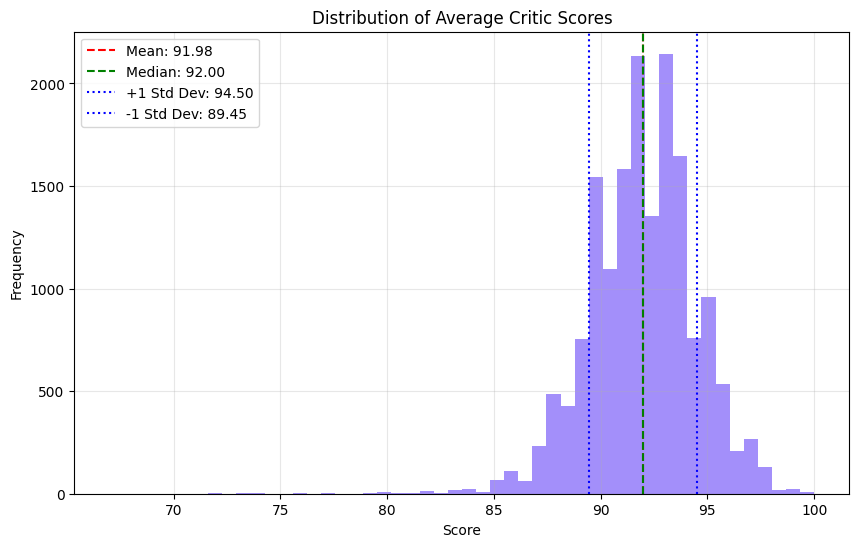

In [ ]:
plt.figure(figsize=(10, 6))
plt.hist(df_info_final['mean_critic_score'], bins=50, color=main_purple, alpha=0.7)
plt.title('Distribution of Average Critic Scores')
plt.xlabel('Score')
plt.ylabel('Frequency')
plt.grid(True, alpha=0.3)

# Add mean, median and std deviation lines
mean_score = df_info_final['mean_critic_score'].mean()
median_score = df_info_final['mean_critic_score'].median()
std_score = df_info_final['mean_critic_score'].std()

plt.axvline(mean_score, color='red', linestyle='--', label=f'Mean: {mean_score:.2f}')
plt.axvline(median_score, color='green', linestyle='--', label=f'Median: {median_score:.2f}')
plt.axvline(mean_score + std_score, color='blue', linestyle=':', label=f'+1 Std Dev: {mean_score + std_score:.2f}')
plt.axvline(mean_score - std_score, color='blue', linestyle=':', label=f'-1 Std Dev: {mean_score - std_score:.2f}')
plt.legend()

plt.show()

### Market Level Analysis

In [ ]:
df_info_final[df_info_final['bottle_qty'] > 0].shape

(3424, 39)

In [ ]:
# Get today's date
today = datetime.today()

from_date = today.replace(year=today.year - 10).strftime('%Y-%m-%d')
to_date ="2025-04-30"
print("from_date =", from_date)

# lwin11s = df_info_final['lwin11'].to_list()
lwin11s =df_info_final[df_info_final['bottle_qty'] > 0]['lwin11'].to_list()
pw_index = make_true_price_weight_index(df_time.loc[from_date:to_date][lwin11s])
ew_index  = make_equal_weight_index_smoothed_2(df_time.loc[from_date:to_date][lwin11s])

lookback_years = 10

index_note = f"Based on a basket of {len(lwin11s)} {REPORT_NAME.lower()} vintages priced above £{LABEL_MEAN_PRICE_MIN} per 12x75cl case."

plot_index_enhanced(pw_index['index_value'], 
                    watermark_path, 
                    main_purple,
                    title=f'{lookback_years}-Year Price Weighted Index - {REPORT_NAME}', 
                    height=700, 
                    note=index_note)

start_value = pw_index['index_value'].iloc[0]
end_value = pw_index['index_value'].iloc[-1]
cagr = (((end_value/start_value) ** (1/lookback_years) - 1) * 100).round(1)
print(f"{lookback_years}-year PW Index CAGR: {cagr}%")
# pw_index.to_csv('data/25-06-17_10yr_pw_index.csv')

from_date = 2015-06-17


10-year PW Index CAGR: 11.8%


In [ ]:
plot_index_enhanced(ew_index['index_value'], 
                    watermark_path, 
                    main_purple,
                    title=f'{lookback_years}-Year Equal Weighted Index - {REPORT_NAME}', 
                    height=700, 
                    note=index_note)

start_value = ew_index['index_value'].iloc[0]
end_value = ew_index['index_value'].iloc[-1]
cagr = (((end_value/start_value) ** (1/lookback_years) - 1) * 100).round(1)
print(f"{lookback_years}-year PW Index CAGR: {cagr}%")

10-year PW Index CAGR: 10.6%


## Divergance

In [ ]:
# Get today's date
today = datetime.today()

from_date = "2015-05-01"
to_date = "2025-05-01"

print("from_date =", from_date)

# lwin11s = df_info_final['lwin11'].to_list()
lwin11s = df_info_final[df_info_final['bottle_qty'] > 0]['lwin11'].to_list()
pw_index_recent = make_true_price_weight_index(df_time.loc[from_date:to_date][lwin11s])
ew_index_recent  = make_equal_weight_index_smoothed_2(df_time.loc[from_date:to_date][lwin11s])

# Combine the DataFrames into a dictionary
returns_dict = {
    'Price Weighted Index': pw_index_recent['index_value'],
    'Equal Weighted Index': ew_index_recent['index_value']
}

# Plot using the provided function
plot_indices_plotly(returns_dict, 
                    watermark_path=watermark_path,
                    title=f'{REPORT_NAME} - Price Weighted vs Equal Weighted Indices', 
                    note='Source: Price data from Liv-ex',
                    colours=colours)

from_date = 2015-05-01


### Trades and transactions

In [ ]:
# lx_trades = pd.read_csv('data/25-05-00_02_raw_data_added_features.csv')
lx_trades = pd.read_csv('/Users/AaranDaniel/Desktop/git_not/25-04-29_trade_discount_to_best_list_price/data/02_raw_data_added_features.csv', dtype={'lwin7': str, 'lwin11': str, 'vintage': str})
print(lx_trades['trade_date'].max())
lx_trades.head()

2025-05-17


lwin7       lwin11              lwin18  trade_date  pack_size  \
0  1082861  10828612015  108286120150600750  2025-04-18        6.0   
1  1135479  11354792018  113547920180600750  2025-04-13        6.0   
2  1012387  10123872009  101238720091200750  2025-04-18       12.0   
3  1013544  10135442018  101354420180600750  2025-04-16        6.0   
4  1007521  10075212016  100752120160600750  2025-04-19        6.0   

   bottle_size  trade_price  trade_price_per_ml  \
0        750.0        685.0            0.152222   
1        750.0        245.0            0.054444   
2        750.0       1500.0            0.166667   
3        750.0       2000.0            0.444444   
4        750.0        449.0            0.099778   

   trade_price_twelve_pack_normalised  lx_market_price  ... trade_age  \
0                              1370.0           1470.0  ...      10.0   
1                               490.0            504.0  ...       7.0   
2                              1500.0           1550.0  ...      16.0   
3                              4000.0           4160.0  ...       7.0   
4                               898.0            950.0  ...       9.0   

   bottle_qty  wc_best_price wc_lx_price_diff_pct  \
0      1185.0         1600.0             8.843537   
1        30.0          505.0             0.198413   
2       315.0         1520.0            -1.935484   
3       103.0         4150.0            -0.240385   
4       468.0          950.0             0.000000   

                                      ws_region vintage_numeric  \
0                                     Champagne          2015.0   
1                                         other          2018.0   
2  Bordeaux-left-bank-reds-medoc-pessac-leognan          2009.0   
3  Bordeaux-left-bank-reds-medoc-pessac-leognan          2018.0   
4   Bordeaux-right-bank-reds-pomerol-st-emilion          2016.0   

                                   ws_region-vintage  \
0                                     Champagne-2015   
1                                         other-2018   
2  Bordeaux-left-bank-reds-medoc-pessac-leognan-2009   
3  Bordeaux-left-bank-reds-medoc-pessac-leognan-2018   
4   Bordeaux-right-bank-reds-pomerol-st-emilion-2016   

                                      region-vintage ws_vintage_score  \
0                                     Champagne-2015             94.0   
1                                                NaN              NaN   
2  Bordeaux-left-bank-reds-medoc-pessac-leognan-2009             97.0   
3  Bordeaux-left-bank-reds-medoc-pessac-leognan-2018             96.0   
4   Bordeaux-right-bank-reds-pomerol-st-emilion-2016             94.0   

   hundred_pointer  
0            False  
1            False  
2            False  
3            False  
4            False  

[5 rows x 35 columns]

**How to add trades in:** 
1. Retrieve all trades from the db 
2. Calculate their difference from price_clean at the date of trade 
3. Plot this on a graph, all data points
4. For each month calculate the X week mean trade discount to MP

In [ ]:
# Calculate date 10 years ago from max trade date
ten_years_ago = pd.to_datetime(lx_trades['trade_date'].max()) - pd.DateOffset(years=10)

# Convert trade_date to datetime before comparison
lx_trades['trade_date'] = pd.to_datetime(lx_trades['trade_date'])

# Filter trades from last 10 years and matching lwin11s
last_ten_trade = lx_trades[(lx_trades['trade_date'] > ten_years_ago) & (lx_trades['lwin11'].isin(lwin11s))]
last_ten_trade['trade_discount_to_market_price'] = -last_ten_trade['trade_discount_to_market_price']
last_ten_trade.shape

/var/folders/8r/dqs6y1qn77d917x96kct6x5h0000gn/T/ipykernel_30304/2928085468.py:9: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



(3237, 35)

/var/folders/8r/dqs6y1qn77d917x96kct6x5h0000gn/T/ipykernel_30304/760015662.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



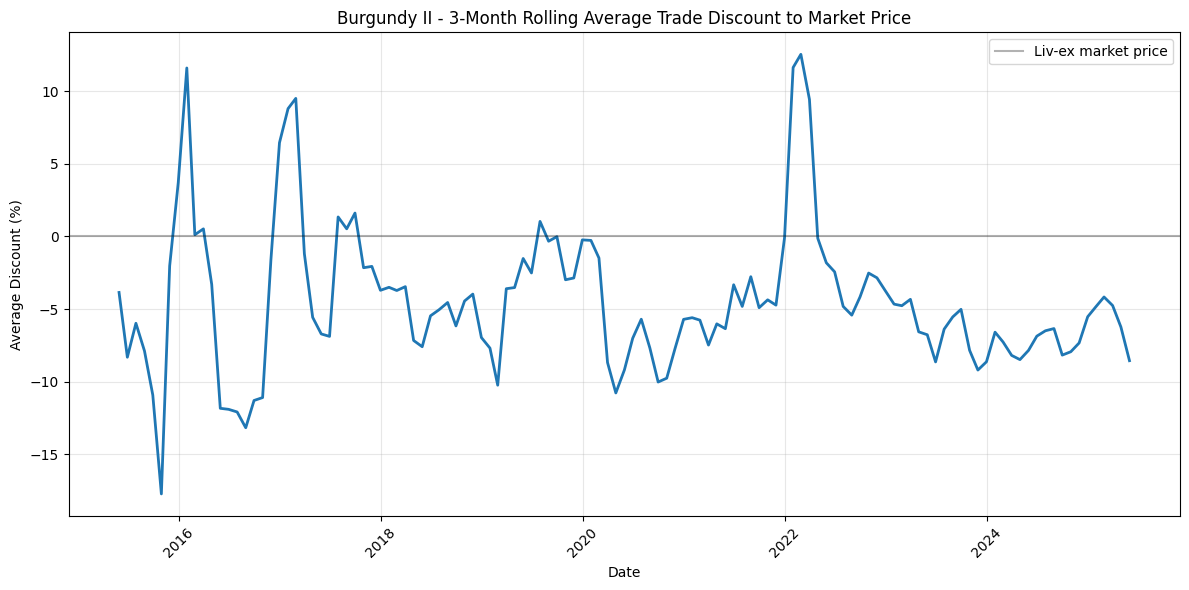

In [ ]:
# Convert trade_date to datetime and sort
last_ten_trade['trade_date'] = pd.to_datetime(last_ten_trade['trade_date'])
last_ten_trade_plot = last_ten_trade.copy()
last_ten_trade_plot = last_ten_trade_plot.sort_values('trade_date')

# Calculate 3-month rolling average of trade discounts
rolling_discounts_trade = last_ten_trade_plot.set_index('trade_date')['trade_discount_to_market_price'].resample('M').mean().rolling(window=3, min_periods=1).mean().reset_index()
rolling_discounts_trade.columns = ['trade_date', 'rolling_3mo_discount']

# Plot rolling average trade discounts
plt.figure(figsize=(12, 6))
plt.plot(rolling_discounts_trade['trade_date'], rolling_discounts_trade['rolling_3mo_discount'], linewidth=2)
plt.axhline(y=0, color='black', linestyle='-', alpha=0.3, label='Liv-ex market price')
plt.title(f'{REPORT_NAME} - 3-Month Rolling Average Trade Discount to Market Price')
plt.xlabel('Date')
plt.ylabel('Average Discount (%)')
plt.grid(True, alpha=0.3)
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.show()

In [ ]:
# Set index to date for rolling_discounts_trad
rolling_discounts_trade_plot = rolling_discounts_trade.set_index('trade_date')

# Combine rolling_discounts_trade with pw_index
combined_index = pw_index.join(rolling_discounts_trade_plot['rolling_3mo_discount'])

# Calculate trade adjusted index value 
combined_index['index_value_trade_adjusted'] = combined_index['index_value'] * (1 + combined_index['rolling_3mo_discount']/100)

# # Create a line plot comparing index values
# plt.figure(figsize=(12, 6))
# plt.plot(combined_index.index, combined_index['index_value'], label='Index Value', linewidth=2)
# plt.plot(combined_index.index, combined_index['index_value_trade_adjusted'], label='Trade Adjusted Index Value', linewidth=2)
# plt.title(f'{REPORT_NAME} - Index Value vs Trade Adjusted Index Value')
# plt.xlabel('Date')
# plt.ylabel('Index Value')
# plt.grid(True, alpha=0.3)
# plt.xticks(rotation=45)
# plt.legend()
# plt.tight_layout()
# plt.show()

In [ ]:
def plot_index_enhanced_dual(df, watermark_path, main_purple, title='', note='Underlying data based on Liv-ex Market prices', height=600):
    """Enhanced plotly version with dual index plotting"""
    fig = go.Figure()

    # Main index trace
    fig.add_trace(go.Scatter(
        x=df.index, 
        y=df['index_value'], 
        mode='lines', 
        name='Market Price Index',
        line=dict(color=main_purple, width=4)
    ))
    
    # Trade adjusted index trace
    fig.add_trace(go.Scatter(
        x=df.index, 
        y=df['index_value_trade_adjusted'], 
        mode='lines', 
        name='Trade Adjusted Index',
        line=dict(color='#FF6347', width=3)  # Using a complementary color
    ))
    
    # Enhanced layout styling
    fig.update_layout(
        title=dict(
            text=title,
            x=0.5,
            xanchor='center',
            yanchor='top',
            font=dict(size=24, family='Avenir, Arial, sans-serif')
        ),
        xaxis=dict(
            tickformat='%Y',
            dtick='M12',
            showgrid=False,
            showline=True,
            linewidth=2,
            linecolor=main_purple,
            tickangle=315
        ),
        yaxis=dict(
            title='Index Value',
            showgrid=True,
            gridwidth=1,
            gridcolor='#E5E5E5',
            showline=True,
            linewidth=2,
            linecolor=main_purple,
            title_standoff=20
        ),
        plot_bgcolor='white',
        paper_bgcolor='white',
        font=dict(family='Avenir, Arial, sans-serif', size=15),
        legend=dict(
            orientation="h",
            yanchor="middle",
            y=1.02,
            xanchor="right",
            x=1
        ),
        width=1000,
        height=height,
        margin=dict(l=80, r=80, t=100, b=80)
    )
    
    # Add note with custom styling
    if note:
        fig.add_annotation(
            xref="paper", yref="paper",
            x=0.01, y=0.00,
            text=note,
            showarrow=False,
            font=dict(size=11, color=main_purple, family='Avenir, Arial, sans-serif'),
            align="left"
        )
    
    if watermark_path is not None: 
        # Include watermark
        watermark = Image.open(watermark_path)
        fig.add_layout_image(
            dict(
                source=watermark,
                xref="paper", yref="paper",
                x=0.52, y=0.5,  # Positioning the logo at the center
                xanchor='center', yanchor='middle',
                sizex=0.8, sizey=0.8,  # Adjust the size of the logo
                opacity=0.65,
                layer="above"
            ))
        
    fig.show()

plot_index_enhanced_dual(combined_index, 
                    watermark_path, 
                    main_purple,
                    title=f'{lookback_years}-Year Price Weighted Index - {REPORT_NAME}', 
                    height=700, 
                    note=index_note)

start_value = pw_index['index_value'].iloc[0]
end_value = pw_index['index_value'].iloc[-1]
cagr = (((end_value/start_value) ** (1/lookback_years) - 1) * 100).round(1)
print(f"{lookback_years}-year PW Index CAGR: {cagr}%")

10-year PW Index CAGR: 11.8%


### Wines that have traded for more this year than they traded for last year

In [ ]:
price_min = 2400

# Filter for trades from 2024 onwards
recent_reg_trades = last_ten_trade[(last_ten_trade['trade_date'].dt.year >= 2024) & (last_ten_trade['bottle_size']  == 750.0)].copy()

# Get lwin11s with at least 2 trades in this period
lwin11_counts = recent_reg_trades['lwin11'].value_counts()
valid_lwin11s = lwin11_counts[lwin11_counts >= 2].index

# Filter for those lwin11s
recent_trades_filtered = recent_reg_trades[(recent_reg_trades['lwin11'].isin(valid_lwin11s)) & (recent_reg_trades['lx_market_price'] > price_min)]

# Calculate average price per ml for each lwin11 by year
yearly_avg_prices = recent_trades_filtered.groupby(['lwin11', recent_trades_filtered['trade_date'].dt.year])['trade_price_per_ml'].mean().unstack()

# Find lwin11s where 2025 price > 2024 price
higher_in_2025 = yearly_avg_prices[yearly_avg_prices[2025] > yearly_avg_prices[2024]].copy()

# Calculate price increase percentage
higher_in_2025['price_increase_pct'] = ((higher_in_2025[2025] - higher_in_2025[2024]) / higher_in_2025[2024]) * 100

# Reset index
higher_in_2025 = higher_in_2025.rename(columns={2024: '2024 Mean Trade Price per ml', 
                                                2025: '2025 Trade Price per ml', 'price_increase_pct': 'Price Increase %'}).reset_index()
# Display results

high_risers = higher_in_2025[higher_in_2025['Price Increase %'] >= 5]

high_risers.to_csv('data/25-06-05_wines_traded_more_this_year_than_last.csv', index=False)
high_risers

trade_date       lwin11  2024 Mean Trade Price per ml  \
2           10286582011                      2.444444   
4           10288922019                      0.688889   
5           10305302016                      0.382889   
6           10305302019                      0.435111   
9           10496392017                      0.385111   
11          10563302019                      0.333333   
12          10568062021                      0.308778   
13          10570052018                      2.511111   
14          10617762015                      0.285333   
15          10619782013                      0.372667   
16          10621352017                      0.640000   
18          10792852019                      1.022000   

trade_date  2025 Trade Price per ml  Price Increase %  
2                          2.777778         13.636364  
4                          0.738222          7.161290  
5                          0.473333         23.621590  
6                          0.464889          6.843718  
9                          0.420889          9.290248  
11                         0.354222          6.266667  
12                         0.357111         15.653113  
13                         3.222222         28.318584  
14                         0.333778         16.978193  
15                         0.441111         18.366130  
16                         0.711111         11.111111  
18                         1.133333         10.893673

## Auction Trades

In [ ]:
auction_trades = pd.read_csv('data/2025-05-08_matched_auction_data.csv', dtype={'LWIN7': str, 'vintage': str})
auction_trades.head()

/var/folders/8r/dqs6y1qn77d917x96kct6x5h0000gn/T/ipykernel_30304/129571794.py:1: DtypeWarning:

Columns (16,19,20) have mixed types. Specify dtype option on import or set low_memory=False.



auction_continent        date  hammer_price_incl_premium  \
0              Asia  2025-01-18                  14190.000   
1           Oceania  2024-12-22                   2434.490   
2               NaN  2024-12-13                  10481.000   
3            Europe  2024-12-11                   1641.402   
4     North America  2024-11-22                  13750.000   

   hammer_ppb_no_premium         auction_house  num_of_bottles  \
0            1892.000000  Acker Merrall Condit             6.0   
1            2063.127119              Langtons             1.0   
2            2183.541667              Sothebys             4.0   
3            1367.835000             Bukowskis             1.0   
4            1833.333280  Acker Merrall Condit             6.0   

   ppb_incl_premium  sellers_net  wine_id  live_auction  ...  \
0         2365.0000  1835.240000      501           1.0  ...   
1         2434.4900  1856.814407      501           1.0  ...   
2         2620.2500  1856.010417      501           0.0  ...   
3         1641.4020  1231.051500      501           0.0  ...   
4         2291.6666  1778.333282      501           1.0  ...   

  rating_computed_js standard_rating  drink_low drink_high calculated_ppb  \
0                NaN             NaN     2017.0     2032.0    2365.000000   
1                NaN             NaN     2017.0     2032.0    2434.490000   
2                NaN             NaN     2017.0     2032.0    2620.250000   
3                NaN             NaN     2017.0     2032.0    1641.402000   
4                NaN             NaN     2017.0     2032.0    2291.666667   

  has_price_discrepancy discrepancy_magnitude         price_range    LWIN7  \
0                 False              0.000000  (2662.0, 608611.0]  1028690   
1                 False              0.000000    (1048.6, 2662.0]  1028690   
2                 False              0.000000  (2662.0, 608611.0]  1028690   
3                 False              0.000000    (1048.6, 2662.0]  1028690   
4                 False              0.000067  (2662.0, 608611.0]  1028690   

         LWIN11  
0  1.028690e+10  
1  1.028690e+10  
2  1.028690e+10  
3  1.028690e+10  
4  1.028690e+10  

[5 rows x 47 columns]

In [ ]:
auction_trades['lwin11'] = auction_trades['LWIN7'].astype(str) + auction_trades['vintage'].astype(str)
auction_trades[auction_trades['has_price_discrepancy'] == True]

auction_continent        date  hammer_price_incl_premium  \
1124644               NaN  1999-12-18                     920.00   
1124645               NaN  2001-02-24                      92.00   
1124646               NaN  2002-01-01                     172.50   
1124647               NaN  2002-01-01                      40.25   
1124648               NaN  2002-05-11                     483.00   
...                   ...         ...                        ...   
1138244               NaN  2001-03-30                     460.00   
1138245               NaN  1999-10-30                     207.00   
1138246               NaN  2001-01-26                     126.50   
1138247               NaN  2001-02-24                      80.50   
1138248               NaN  2002-09-21                     690.00   

         hammer_ppb_no_premium         auction_house  num_of_bottles  \
1124644                  66.67  Acker Merrall Condit            12.0   
1124645                  80.00  Acker Merrall Condit             1.0   
1124646                  50.00  Acker Merrall Condit             3.0   
1124647                  35.00  Acker Merrall Condit             1.0   
1124648                  35.00  Acker Merrall Condit            12.0   
...                        ...                   ...             ...   
1138244                 100.00  Acker Merrall Condit             4.0   
1138245                  60.00  Acker Merrall Condit             3.0   
1138246                  55.00  Acker Merrall Condit             2.0   
1138247                  70.00  Acker Merrall Condit             1.0   
1138248                  50.00  Acker Merrall Condit            12.0   

         ppb_incl_premium  sellers_net  wine_id  live_auction  ...  \
1124644         76.666667    66.666667    26702           NaN  ...   
1124645         92.000000    80.000000    26702           NaN  ...   
1124646         57.500000    50.000000    26707           NaN  ...   
1124647         40.250000    35.000000    26710           NaN  ...   
1124648         40.250000    35.000000    26712           NaN  ...   
...                   ...          ...      ...           ...  ...   
1138244        115.000000   100.000000    40827           NaN  ...   
1138245         69.000000    60.000000    40827           NaN  ...   
1138246         63.250000    55.000000    40827           NaN  ...   
1138247         80.500000    70.000000    40827           NaN  ...   
1138248         57.500000    50.000000   349787           NaN  ...   

        standard_rating drink_low  drink_high calculated_ppb  \
1124644            96.0    2009.0      2024.0      76.666667   
1124645            96.0    2009.0      2024.0      92.000000   
1124646            92.0    2008.0      2026.0      57.500000   
1124647             NaN    2018.0      2035.0      40.250000   
1124648            87.0    2010.0      2020.0      40.250000   
...                 ...       ...         ...            ...   
1138244             NaN    2014.0      2020.0     115.000000   
1138245             NaN    2014.0      2020.0      69.000000   
1138246             NaN    2014.0      2020.0      63.250000   
1138247             NaN    2014.0      2020.0      80.500000   
1138248             NaN       NaN         NaN      57.500000   

        has_price_discrepancy discrepancy_magnitude        price_range  \
1124644                  True              9.996667   (488.75, 1048.6]   
1124645                  True             12.000000   (0.999, 224.448]   
1124646                  True              7.500000   (0.999, 224.448]   
1124647                  True              5.250000   (0.999, 224.448]   
1124648                  True              5.250000  (224.448, 488.75]   
...                       ...                   ...                ...   
1138244                  True             15.000000  (224.448, 488.75]   
1138245                  True              9.000000   (0.999, 224.448]   
1138246                  True              8.25000

### Add market price confidence

In [ ]:
df_mp_confidence = get_mp_confidence(engine, lwin11_str)
df_mp_confidence.head()

Successfully retrieved 26742 rows from database


lwin11 market_price_confidence        date
0  10178291986                     Red  2025-06-15
1  10178291994                     Red  2025-06-15
2  10178291995                     Red  2025-06-15
3  10178292007                     Red  2025-06-15
4  10178452005                     Red  2025-06-15

In [ ]:
df_info_final = df_info_final.merge(df_mp_confidence[['lwin11', 'market_price_confidence']], on='lwin11', how='left')

#### Average returns by year

In [ ]:
def plot_average_wine_returns(df_time, lwin11s, REPORT_NAME, note, watermark_path, main_purple):
    
    # Step 1: Calculate yearly returns for each wine
    yearly_returns = df_time[lwin11s].resample('Y').last().pct_change(fill_method=None)

    # Step 2: Calculate average return across all wines for each year
    average_yearly_returns = yearly_returns.median(axis=1)

    # Step 3: Filter for the years
    max_year = df_time.index.year.max() - 1
    average_yearly_returns = average_yearly_returns.loc['2003':str(max_year)]

    # Calculate YTD returns
    current_year = pd.Timestamp.now().year
    ytd_returns = df_time[lwin11s].loc[:pd.Timestamp.now()].resample('Y').last().pct_change(fill_method=None)
    ytd_average = ytd_returns.median(axis=1).iloc[-1]

    # Create DataFrame with the bar chart data
    bar_data = pd.DataFrame({
        'year': list(average_yearly_returns.index.year) + [current_year],
        'average_return': list(average_yearly_returns.values) + [ytd_average],
        'return_type': ['Historical'] * len(average_yearly_returns) + ['YTD']
    })

    # Step 4: Create a Plotly figure
    fig = go.Figure()

    # Add the bar trace for historical years
    fig.add_trace(go.Bar(
        x=average_yearly_returns.index.year,
        y=average_yearly_returns.values,
        text=[f'{value:.2%}' for value in average_yearly_returns.values],
        textposition='outside',
        marker_color='#7c60f9'
    ))

    # Add the YTD bar with different color
    fig.add_trace(go.Bar(
        x=[current_year],
        y=[ytd_average],
        text=[f'{ytd_average:.2%}'],
        textposition='outside',
        marker_color='#ff9900',  # Orange color for YTD
        name='YTD'
    ))

    # Add a horizontal line at y=0
    fig.add_shape(
        type="line",
        x0=average_yearly_returns.index.year.min(),
        y0=0,
        x1=average_yearly_returns.index.year.max(),
        y1=0,
        line=dict(color="#4A4A68", width=2, dash="dash"),
    )

    # Customize the layout
    fig.update_layout(
        title=dict(
            text=f'{REPORT_NAME} - Average Wine Returns by Year (2003-2025)',
            x=0.5,  # Centers the title horizontally
            xanchor='center'
        ),
        xaxis_title='Year',
        yaxis_title='Average Return',
        yaxis_tickformat='.0%',
        xaxis_tickmode='linear',
        xaxis_dtick=1,
        showlegend=False,  
        font=dict(family='Avenir, Arial, sans-serif'),
        height=590
    )

    # Add note with custom styling
    if note:
        fig.add_annotation(
            xref="paper", yref="paper",
            x=0.01, y=0.00,
            text=note,
            showarrow=False,
            font=dict(size=11, color=main_purple, family='Avenir, Arial, sans-serif'),
            align="left"
        )

    # Include watermark
    watermark = Image.open(watermark_path)
    fig.add_layout_image(
        dict(
            source=watermark,
            xref="paper", yref="paper",
            x=0.52, y=0.5,  # Positioning the logo at the center
            xanchor='center', yanchor='middle',
            sizex=0.8, sizey=0.8,  # Adjust the size of the logo
            opacity=0.85,
            layer="above"
        ))

    # Show the plot
    fig.show()
    
    # Return the bar chart data
    return bar_data

avg_returns_note = f"Based on a basket of {len(lwin11s)} {REPORT_NAME.split(' ')[0].lower()} vintages priced above £{LABEL_MEAN_PRICE_MIN} per 12x75cl case. 2025 is year-to-date."
data = plot_average_wine_returns(df_time, lwin11s, REPORT_NAME, avg_returns_note, watermark_path, main_purple)
data.to_csv('data/25-06-17_avg_returns_bar_chart.csv')

In [ ]:
def plot_combined_return_distribution(df_time, lwin11s_by_category, year, REPORT_NAME):
    # Step 1: Calculate one-year returns for all wines
    max_date = df_time.index.max()  # Get the maximum date in the DataFrame
    one_year_ago = max_date - pd.DateOffset(years=1)  # Calculate the date one year ago
    
    fig = go.Figure()
    
    # Color mapping that matches the category names
    color_map = {
        'Green': '#00b050',  # Green color
        'Red': '#ff0000',    # Red color
        'Amber': '#ffc000'   # Amber/Yellow color
    }
    
    # For each category, calculate returns and add to the plot
    for category, lwin11s in lwin11s_by_category.items():
        # Get the prices at the maximum date and one year ago
        prices_now = df_time[lwin11s].loc[max_date]
        prices_one_year_ago = df_time[lwin11s].loc[one_year_ago]

        # Calculate one-year returns and express as percentage
        one_year_returns = ((prices_now - prices_one_year_ago) / prices_one_year_ago) * 100
        
        # Add histogram trace for this category
        fig.add_trace(go.Histogram(
            x=one_year_returns,
            nbinsx=100,  # Reduced number of bins for better visualization
            marker_color=color_map[category],
            opacity=0.6,
            name=category  # Add category name to the legend
        ))
    
    # Customize the layout
    fig.update_layout(
        title=dict(
            text=f'{REPORT_NAME} - Distribution of One-Year Returns by Confidence Level for {year}',
            x=0.5,  # Centers the title horizontally
            xanchor='center'
        ),
        xaxis_title='One-Year Return (%)',
        yaxis_title='Frequency',
        xaxis=dict(range=[-100, 100]),  # Set x-axis limits
        font=dict(family='Avenir, Arial, sans-serif'),
        height=590,
        barmode='overlay',  # Overlay the histograms
        legend_title='Market Price Confidence'
    )
    
    # Show the plot
    fig.show()

# Example usage
# Create a dictionary mapping categories to their LWIN11s
lwin11s_by_category = {
    'Green': df_info_final[df_info_final['market_price_confidence'] == 'Green']['lwin11'].to_list(),
    'Red': df_info_final[df_info_final['market_price_confidence'] == 'Red']['lwin11'].to_list(), 
    'Amber': df_info_final[df_info_final['market_price_confidence'] == 'Amber']['lwin11'].to_list()
}

# Plot all categories on the same plot
plot_combined_return_distribution(df_time, lwin11s_by_category, 2024, REPORT_NAME)

In [ ]:
ws_scores = get_ws_vintage_scores()
df_ws = add_ws_vintage_scores(df_info_final, ws_scores)
df_ws.head()

Successfully created database engine
Successfully retrieved 429 rows from database
(429, 5)
Wine Missing WS vintage scores: 840 (3.14%)


lwin11    lwin7                                               name  \
0  10178291995  1017829       Bertrand Ambroise, Clos de Vougeot Grand Cru   
1  10178452005  1017845  Bertrand Ambroise, Corton Grand Cru, Le Rognet...   
2  10178452012  1017845  Bertrand Ambroise, Corton Grand Cru, Le Rognet...   
3  10179172002  1017917  Bertrand Ambroise, Nuits-Saint-Georges Premier...   
4  10181162019  1018116                  Amiot Servelle, Chambolle-Musigny   

   vintage           producer country    region           sub_region  \
0     1995  Bertrand Ambroise  France  Burgundy      Clos de Vougeot   
1     2005  Bertrand Ambroise  France  Burgundy               Corton   
2     2012  Bertrand Ambroise  France  Burgundy               Corton   
3     2002  Bertrand Ambroise  France  Burgundy  Nuits-Saint-Georges   
4     2019     Amiot Servelle  France  Burgundy    Chambolle-Musigny   

                  site colour  ...  7yr_cagr  5yr_cagr label_average_price  \
0                         Red  ...       NaN       NaN              1083.5   
1  Le Rognet et Corton    Red  ...  0.057258 -0.005095               854.2   
2  Le Rognet et Corton    Red  ...  0.068968  0.007351               854.2   
3        Les Vaucrains    Red  ...  0.120153  0.148407               817.6   
4                 None    Red  ...       NaN       NaN               770.0   

   producer_average_price  age  label_price-age_corr  dw_length  \
0              906.642857   29             -0.715346       10.0   
1              906.642857   19              0.763784        NaN   
2              906.642857   12              0.763784        NaN   
3              906.642857   22              0.389745        8.0   
4             2025.682927    5                   NaN       14.0   

   market_price_confidence  vintage_numeric  ws_vintage_score  
0                      Red             1995              83.0  
1                      Red             2005              98.0  
2                      Red             2012              95.0  
3                      Red             2002              92.0  
4                    Green             2019              95.0  

[5 rows x 42 columns]

In [ ]:
df_ws.to_pickle('research_lab/data/large_files/df_info_final.pkl')

## Ideas: 
Liquidity: 
- Offer depth and trades by vintage 



### Wine Colour:

In [ ]:
# Average prices by wine colour
lwin_count = df_info_final.groupby('colour')['lwin11'].count()
print("Lwin count by wine colour:")
print(lwin_count)
print()

# Average prices by wine colour
average_prices = df_info_final.groupby('colour')['current_price'].mean()
print("Average prices by wine colour:")
print(average_prices)
print()

# Average '7yr_cagr' by wine colour
average_7yr_cagr = df_info_final.groupby('colour')['7yr_cagr'].mean()
print("Average '7yr_cagr' by wine colour:")
print(average_7yr_cagr)
print()

# Average 'lifetime_cagr' by wine colour
average_lifetime_cagr = df_info_final.groupby('colour')['lifetime_cagr'].mean()
print("Average 'lifetime_cagr' by wine colour:")
print(average_lifetime_cagr)
print()

# Average 'mean_critic_score' by wine colour
mean_critic_score = df_info_final.groupby('colour')['mean_critic_score'].mean()
print("Average 'mean_critic_score' by wine colour:")
print(mean_critic_score)

Lwin count by wine colour:
colour
            31
Mixed       23
Red      18081
Rose         4
White     8588
Name: lwin11, dtype: int64

Average prices by wine colour:
colour
         25220.064516
Mixed     4269.913043
Red       7807.276367
Rose      1308.250000
White     6554.804145
Name: current_price, dtype: float64

Average '7yr_cagr' by wine colour:
colour
         0.105654
Mixed    0.014531
Red      0.079092
Rose     0.000000
White    0.094766
Name: 7yr_cagr, dtype: float64

Average 'lifetime_cagr' by wine colour:
colour
         0.091138
Mixed    0.044682
Red      0.061957
Rose     0.068702
White    0.083875
Name: lifetime_cagr, dtype: float64

Average 'mean_critic_score' by wine colour:
colour
               NaN
Mixed          NaN
Red      91.862258
Rose           NaN
White    92.221764
Name: mean_critic_score, dtype: float64


In [ ]:
reds = df_info_final[df_info_final['colour'] == 'Red'].copy()
reds.groupby('name')['lifetime_cagr'].describe()

count      mean       std  \
name                                                                            
Adrien Belland, Corton Grand Cru, Clos de la Vi...    1.0  0.017331       NaN   
Alain Hudelot-Noellat, Chambolle-Musigny             15.0  0.070111  0.074197   
Alain Hudelot-Noellat, Chambolle-Musigny Premie...   31.0  0.059060  0.096134   
Alain Hudelot-Noellat, Clos de Vougeot Grand Cru     41.0  0.072639  0.119329   
Alain Hudelot-Noellat, Nuits-Saint-Georges Prem...   28.0  0.037174  0.103661   
...                                                   ...       ...       ...   
Vincent Girardin, Romanee-Saint-Vivant Grand Cru      2.0  0.200593  0.283681   
Vincent Girardin, Volnay Premier Cru, Santenots       4.0  0.047272  0.068498   
Vincent et Marie Christine Perrin, Pommard, Les...    1.0  0.000000       NaN   
Yann Durieux, Bourgogne, Hautes Cotes de Nuits ...    2.0  0.083700  0.002382   
Yann Durieux, Gevrey-Chambertin, Vieilles Vignes      1.0  0.178673       NaN   

                                                         min       25%  \
name                                                                     
Adrien Belland, Corton Grand Cru, Clos de la Vi...  0.017331  0.017331   
Alain Hudelot-Noellat, Chambolle-Musigny           -0.144997  0.056232   
Alain Hudelot-Noellat, Chambolle-Musigny Premie... -0.337536  0.000000   
Alain Hudelot-Noellat, Clos de Vougeot Grand Cru   -0.110812  0.000000   
Alain Hudelot-Noellat, Nuits-Saint-Georges Prem... -0.300469  0.004691   
...                                                      ...       ...   
Vincent Girardin, Romanee-Saint-Vivant Grand Cru    0.000000  0.100297   
Vincent Girardin, Volnay Premier Cru, Santenots    -0.044380  0.026693   
Vincent et Marie Christine Perrin, Pommard, Les...  0.000000  0.000000   
Yann Durieux, Bourgogne, Hautes Cotes de Nuits ...  0.082016  0.082858   
Yann Durieux, Gevrey-Chambertin, Vieilles Vignes    0.178673  0.178673   

                                                         50%       75%  \
name                                                                     
Adrien Belland, Corton Grand Cru, Clos de la Vi...  0.017331  0.017331   
Alain Hudelot-Noellat, Chambolle-Musigny            0.071563  0.118968   
Alain Hudelot-Noellat, Chambolle-Musigny Premie...  0.097568  0.113970   
Alain Hudelot-Noellat, Clos de Vougeot Grand Cru    0.079759  0.104472   
Alain Hudelot-Noellat, Nuits-Saint-Georges Prem...  0.072035  0.090967   
...                                                      ...       ...   
Vincent Girardin, Romanee-Saint-Vivant Grand Cru    0.200593  0.300890   
Vincent Girardin, Volnay Premier Cru, Santenots     0.056188  0.076767   
Vincent et Marie Christine Perrin, Pommard, Les...  0.000000  0.000000   
Yann Durieux, Bourgogne, Hautes Cotes de Nuits ...  0.083700  0.084542   
Yann Durieux, Gevrey-Chambertin, Vieilles Vignes    0.178673  0.178673   

                                                         max  
name                                                          
Adrien Belland, Corton Grand Cru, Clos de la Vi...  0.017331  
Alain Hudelot-Noellat, Chambolle-Musigny            0.147787  
Alain Hudelot-Noellat, Chambolle-Musigny Premie...  0.187485  
Alain Hudelot-Noellat, Clos de Vougeot Grand Cru    0.683948  
Alain Hudelot-Noellat, Nuits-Saint-Georges Prem...  0.158021  
...                                                      ...  
Vincent Girardin, Romanee-Saint-Vivant Grand Cru    0.401186  
Vincent Girardin, Volnay Premier Cru, Santenots     0.121093  
Vincent et Marie Christine Perrin, Pommard, Les...  0.000000  
Yann Durieux, Bourgogne, Hautes Cotes de Nuits ...  0.085385  
Yann Durieux, Gevrey-Chambertin, Vieilles Vignes    0.178673  

[1663 rows x 8 columns]

# Regional Analysis

In [ ]:
def WIS_grouped_table(df, group_min_observations=1, grouping='producer', liquidity_influence=0.3, rounding=4):
    
    # Calculate the WineFi Investment Score (WIS) for a group of wines.

    # Drop rows with null cagr values for both 7yr and 5yr CAGR
    df_non_null = df.dropna(subset=['7yr_cagr', '5yr_cagr'], how='all').copy()
    
    # Set the appropriate capitalization for the grouping column name
    if grouping == 'name' or grouping == 'lwin7':
        grouping_cap = "Label"
    elif grouping == 'sub_region':
        grouping_cap = "Sub-Region"
    else:
        grouping_cap = grouping.capitalize()
    
    # Define column names for various calculated metrics
    vc_name = f"{grouping_cap} VC Ratio"
    ra_vc_name = f"{grouping_cap} Ret-Adj VC Ratio"
    normalized_ra_vc_name = f"{grouping_cap} Score"

    # Count unique LWIN11 codes for each group
    lwin11_counts = df_non_null.groupby(grouping)['lwin11'].nunique()
    df_non_null[f'{grouping}_lwin11_count'] = df_non_null[grouping].map(lwin11_counts)
    
    # Filter out groups with insufficient observations
    df_filtered = df_non_null[df_non_null[f'{grouping}_lwin11_count'] >= group_min_observations]

    # Function to calculate combined CAGR and standard deviation
    def combined_cagr_stats(group):
        cagr_10yr = group['10yr_cagr'].dropna()
        cagr_7yr = group['7yr_cagr'].dropna()
        cagr_5yr = group['5yr_cagr'].dropna()
        cagr_lifetime = group['lifetime_cagr'].dropna()

        # Combine 10yr, 7yr, and 5yr CAGR in prioritized order
        combined_cagr = pd.concat([
            cagr_10yr,
            cagr_7yr[~cagr_7yr.index.isin(cagr_10yr.index)],
            cagr_5yr[~cagr_5yr.index.isin(cagr_10yr.index) & ~cagr_5yr.index.isin(cagr_7yr.index)]
        ])

        return pd.Series({
            'combined_cagr_mean': combined_cagr.mean(),
            'combined_cagr_std': combined_cagr.std(),
            'cagr_10yr_mean': cagr_10yr.mean(),
            'cagr_7yr_mean': cagr_7yr.mean(),
            'cagr_5yr_mean': cagr_5yr.mean(),
            'lifetime_cagr_mean': cagr_lifetime.mean(),
            'count': len(combined_cagr)
        })
        
    # Perform grouping and aggregation
    grouped_table = df_filtered.groupby(grouping).apply(combined_cagr_stats)
    grouped_table['current_price'] = df_filtered.groupby(grouping)['current_price'].mean()
    grouped_table['lwin11_count'] = df_filtered.groupby(grouping)['lwin11'].nunique()
    grouped_table['avg_bottle_qty'] = df_filtered.groupby(grouping)['bottle_qty'].mean()

    # Handle NaN values
    grouped_table = grouped_table.fillna(0)

    # Calculate Vintage Consistency (VC) Ratio
    grouped_table[vc_name] = (grouped_table['combined_cagr_mean'] / grouped_table['combined_cagr_std']).round(2)
    
    # Make VC Ratio negative if the wine has negative average CAGR
    grouped_table[vc_name] = grouped_table.apply(
        lambda row: -abs(row[vc_name]) if row['combined_cagr_mean'] < 0 else row[vc_name],
        axis=1
    )
    
    # Calculate the Return-Adjusted VC Ratio
    grouped_table['Avg. Lifetime CAGR (%)'] = (grouped_table['lifetime_cagr_mean'] * 100).round(2)
    
    # Make sure double-negatives are outputted as a negative 
    def process_row(row):
        if row['combined_cagr_mean'] < 0 and row[vc_name] < 0:
            # print(f"Both 'combined_cagr_mean' and '{vc_name}' are negative for row index {row.name}. Keeping the result negative.")
            return -(row[vc_name] * row['combined_cagr_mean']).round(rounding)
        else:
            return abs(row[vc_name] * row['combined_cagr_mean']).round(rounding)

    grouped_table[ra_vc_name] = grouped_table.apply(process_row, axis=1)
    
    # Sort and format grouped_table
    table_sorted = grouped_table.sort_values(by=ra_vc_name, ascending=False)
    table_sorted['Std Dev. (%)'] = (table_sorted['combined_cagr_std'] * 100).round(rounding)
    table_sorted['Average Price'] = table_sorted['current_price'].round(0)
    table_sorted['Avg. 7yr CAGR (%)'] = (table_sorted['cagr_7yr_mean'] * 100).round(rounding)
    table_sorted['Avg. 5yr CAGR (%)'] = (table_sorted['cagr_5yr_mean'] * 100).round(rounding)
    
    # Calculate liquidity factors based on LWIN11 count and distinct price/year
    lwin11_factor = table_sorted['lwin11_count'] / table_sorted['lwin11_count'].max()
    
    # Combine factors using geometric mean
    combined_factor = (lwin11_factor).pow(liquidity_influence)

    # Calculate normalized and liquidity-adjusted ranking
    table_sorted[normalized_ra_vc_name] = (
        (table_sorted[ra_vc_name] * combined_factor).rank(method='min', ascending=True) / 
        len(table_sorted) * 100
    ).round(rounding)

    # Select and reorder columns for final output
    table_sorted = table_sorted[[
        'Avg. Lifetime CAGR (%)', 'Avg. 7yr CAGR (%)', 'Avg. 5yr CAGR (%)', 'Std Dev. (%)', 'Average Price', 
        vc_name, ra_vc_name, normalized_ra_vc_name, 'lwin11_count'
    ]]
    
    # Join new columns to the original DataFrame
    df_with_ratios = df_non_null.merge(
        table_sorted[[vc_name, ra_vc_name, normalized_ra_vc_name]], 
        left_on=grouping, right_index=True, how='left'
    )

    table_sorted['Avg. Lifetime CAGR (%)'] = table_sorted['Avg. Lifetime CAGR (%)'].round(0)
    table_sorted['Avg. 7yr CAGR (%)'] = table_sorted['Avg. 7yr CAGR (%)'].round(0)
    table_sorted['Avg. 5yr CAGR (%)'] = table_sorted['Avg. 5yr CAGR (%)'].round(0)
    table_sorted['Std Dev. (%)'] = table_sorted['Std Dev. (%)'].round(0)
    table_sorted['Average Price'] = table_sorted['Average Price'].round(0)

    return table_sorted.sort_values(by=normalized_ra_vc_name, ascending=False), df_with_ratios

In [ ]:
# Run code 
group = 'region'
print(f"Total number of {group.replace('_',' ').capitalize()}", df_info_final[group].nunique())
subregion_table_sorted, df_with_ratios = WIS_grouped_table(df_info_final, group_min_observations=15, grouping=group, liquidity_influence=0.3)
find_top_table = pd.merge(subregion_table_sorted.reset_index(), df_info[[group]], on=group, how='left')
find_top_table.rename(columns={'region' : 'Region', group: group.replace('_',' ').capitalize()}, inplace=True)
find_top_table.drop_duplicates(inplace=True)
find_top_table

# find_top_table.drop(columns=['Sub-Region VC Ratio', 'Sub-Region Ret-Adj VC Ratio', 'Region']).head(22)

Total number of Region 1


Region  Avg. Lifetime CAGR (%)  Avg. 7yr CAGR (%)  Avg. 5yr CAGR (%)  \
0  Burgundy                     8.0                8.0                8.0   

   Std Dev. (%)  Average Price  Region VC Ratio  Region Ret-Adj VC Ratio  \
0           8.0         8670.0             1.15                   0.1019   

   Region Score  lwin11_count  
0         100.0         18730

## Producer table

In [ ]:
# Run code 
print('Total number of producers', df_info_final['producer'].nunique())
prod_table_sorted, df_with_ratios = WIS_grouped_table(df_info_final, group_min_observations=6, grouping='producer', liquidity_influence=0.3)
find_top_prods = pd.merge(prod_table_sorted.reset_index(), df_info[['region','producer']], on='producer', how='left')
find_top_prods.rename(columns={'region' : 'Region', 'producer': 'Producer'}, inplace=True)
find_top_prods.drop_duplicates(inplace=True)
find_top_prods.drop(columns=['Producer VC Ratio', 'Producer Ret-Adj VC Ratio', 'Region']).dropna().head(20)

Total number of producers 485


Producer  Avg. Lifetime CAGR (%)  \
0                        Domaine Bizot                    22.0   
59                   Domaine d'Auvenay                    24.0   
215                      Domaine Leroy                    16.0   
821              Domaine Bernard Bonin                    30.0   
876                        Hubert Lamy                    19.0   
1008           Domaine Armand Rousseau                    12.0   
1458                Domaine Rene Engel                    15.0   
1505                  Domaine Leflaive                    10.0   
1935           Pierre-Yves Colin-Morey                    14.0   
2412         Domaine Francois Raveneau                    11.0   
2759       Domaine de la Romanee-Conti                    11.0   
3153     Domaine du Comte Liger Belair                    15.0   
3209                      Prieure Roch                    15.0   
3516  Domaine Georges Mugneret Gibourg                    12.0   
3772            Domaine Arnoux-Lachaux                    13.0   
4206               Jean-Claude Ramonet                    10.0   
4734        Domaine Bonneau du Martray                    10.0   
4803           Domaine Georges Roumier                    11.0   
5247                     Domaine Dujac                    10.0   
5738                    Vincent Dancer                    19.0   

      Avg. 7yr CAGR (%)  Avg. 5yr CAGR (%)  Std Dev. (%)  Average Price  \
0                  29.0               25.0          11.0        30784.0   
59                 25.0               21.0          12.0        83688.0   
215                18.0               15.0          10.0        67938.0   
821                31.0               31.0          13.0         4530.0   
876                20.0               24.0          11.0         4483.0   
1008               12.0               10.0           6.0        16356.0   
1458               17.0               14.0           9.0        23750.0   
1505               12.0               14.0           6.0        18702.0   
1935               14.0               13.0           7.0         4201.0   
2412               12.0               13.0           6.0         6923.0   
2759                7.0                7.0           5.0        58686.0   
3153               17.0               13.0           6.0        23707.0   
3209               17.0               11.0           9.0        10150.0   
3516               13.0               12.0           7.0         5998.0   
3772               17.0               21.0          11.0         4474.0   
4206               12.0               12.0           7.0         9035.0   
4734               12.0               12.0           4.0         3269.0   
4803               10.0                7.0           7.0        28455.0   
5247               12.0               11.0           7.0        11495.0   
5738               18.0               19.0          10.0         3369.0   

      Producer Score  lwin11_count  
0           100.0000            38  
59           99.6441           117  
215          99.2883           500  
821          98.9324            29  
876          98.5765            79  
1008         98.2206           378  
1458         97.8648            42  
1505         97.5089           334  
1935         97.1530           295  
2412         96.7972           260  
2759         96.4413           330  
3153         96.0854            48  
3209         95.7295           192  
3516         95.3737           187  
3772         95.0178           312  
4206         94.6619           373  
4734         94.3060            53  
4803         93.9502           326  
5247         93.5943           353  
5738         93.2384            37

In [ ]:
prods_to_export = find_top_prods.drop(columns=['Producer VC Ratio', 'Producer Ret-Adj VC Ratio', 'Region']).dropna()
prods_to_export

Producer  Avg. Lifetime CAGR (%)  Avg. 7yr CAGR (%)  \
0              Domaine Bizot                    22.0               29.0   
59         Domaine d'Auvenay                    24.0               25.0   
215            Domaine Leroy                    16.0               18.0   
821    Domaine Bernard Bonin                    30.0               31.0   
876              Hubert Lamy                    19.0               20.0   
...                      ...                     ...                ...   
25603   Chanson Pere et Fils                     2.0                1.0   
25634            Mark Haisma                     2.0                1.0   
25665           Louis Latour                     1.0                1.0   
25699             Louis Remy                     1.0                0.0   
25708      Francois Feuillet                     1.0               -1.0   

       Avg. 5yr CAGR (%)  Std Dev. (%)  Average Price  Producer Score  \
0                   25.0          11.0        30784.0        100.0000   
59                  21.0          12.0        83688.0         99.6441   
215                 15.0          10.0        67938.0         99.2883   
821                 31.0          13.0         4530.0         98.9324   
876                 24.0          11.0         4483.0         98.5765   
...                  ...           ...            ...             ...   
25603               -2.0           6.0         1109.0          1.7794   
25634                1.0           7.0         1621.0          1.4235   
25665                1.0           6.0         1598.0          1.0676   
25699                2.0           4.0         1650.0          0.7117   
25708               -0.0           3.0         1890.0          0.3559   

       lwin11_count  
0                38  
59              117  
215             500  
821              29  
876              79  
...             ...  
25603            19  
25634            14  
25665            25  
25699             7  
25708            11  

[281 rows x 8 columns]

In [ ]:
# prods_to_export.to_csv('data/25-06-12_top_producers_champagne.csv', index=False)

### Top Producer Index

In [ ]:
producer_list = find_top_prods[find_top_prods['Producer Score']>=75]['Producer'].to_list()
lwin11s_top = df_info_final[df_info_final['producer'].isin(producer_list)]['lwin11'].to_list()
print(len(lwin11s_top))
pw_index_top = make_true_price_weight_index(df_time.loc[from_date:][lwin11s_top])
ew_index_top = make_equal_weight_index_smoothed_2(df_time.loc[from_date:][lwin11s_top])
plot_index_enhanced(ew_index_top['index_value'], 
                    title=f'10 Year Equal-weighted Index - {REPORT_NAME} Top 1/4 Producers', 
                    height=700, 
                    note=f'Based on a basket of {len(lwin11s_top)} {REPORT_NAME} vintages priced above £{LABEL_MEAN_PRICE_MIN} per case from top producers.', 
                    watermark_path=None,
                    main_purple=main_purple)


start_value = ew_index_top['index_value'].iloc[0]
end_value = ew_index_top['index_value'].iloc[-1]
cagr = (((end_value/start_value) ** (1/lookback_years) - 1) * 100).round(1)
print(f"{lookback_years}-year EW top producer Index CAGR: {cagr}%")

13327


10-year EW top producer Index CAGR: 24.5%


In [ ]:
ew_index_top.to_csv('data/25-06-17_ew_index_top_quarter_producers.csv')

### Correlation Matrix 

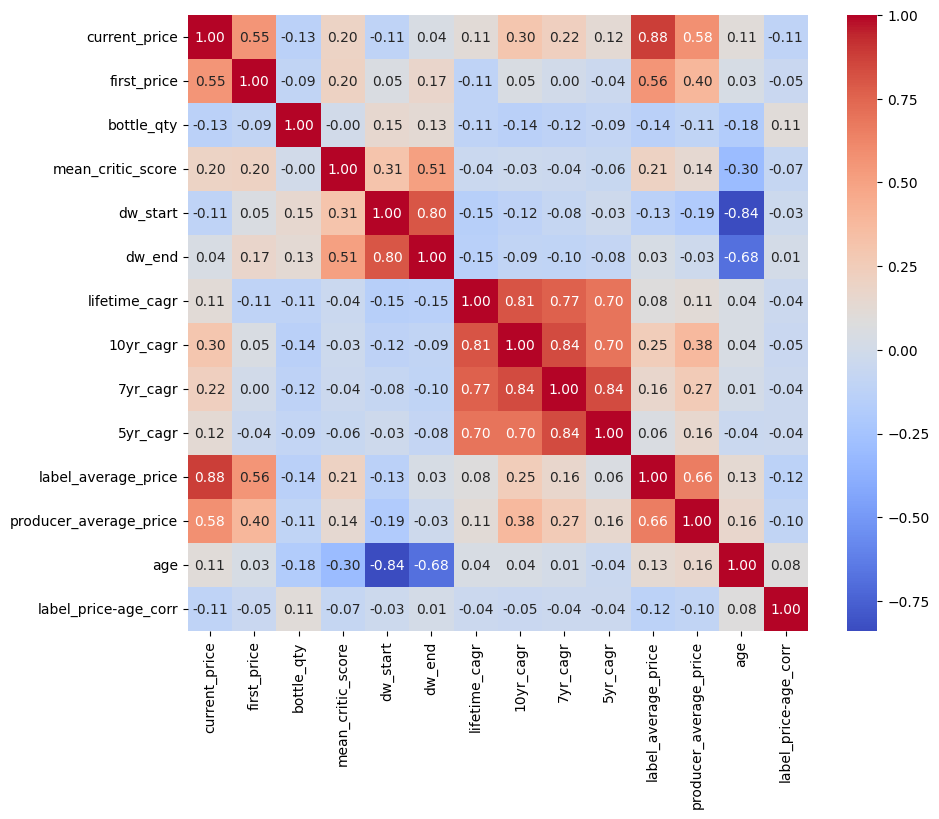

In [ ]:
corr_cols = ['current_price', 'first_price', 'bottle_qty', 'mean_critic_score', 'dw_start',
       'dw_end', 'lifetime_cagr', '10yr_cagr', '7yr_cagr', '5yr_cagr', 'label_average_price', 'producer_average_price', 'age',
       'label_price-age_corr']

# Assuming df_filtered is your DataFrame
correlation_matrix = df_info_final[corr_cols].corr()

# Create a heatmap using seaborn
plt.figure(figsize=(10, 8))  # Adjust the figure size if needed
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f')

# Display the plot
plt.show()

### Critic Scores
- Do they correlate with prices.
- Do they correlate with returns.
- What do they correlate with? 

In [ ]:
df_info_final['high_score'] = df_info_final['mean_critic_score'] > 91
df_info_final.groupby('high_score')['lifetime_cagr'].describe()

count      mean       std       min     25%       50%      75%  \
high_score                                                                     
False       15776.0  0.069228  0.157613 -0.940870  0.0000  0.057316  0.11483   
True        10682.0  0.068713  0.118105 -0.877148  0.0205  0.067964  0.11340   

                 max  
high_score            
False       3.670353  
True        2.914086

In [ ]:
def plot_score_vs_returns(region, df, threshold = 91):
    # First plot - All scores
    df_info_final_scored = df[df['mean_critic_score'].notna()].copy()
    df_info_final_scored['high_score'] = df_info_final_scored['mean_critic_score'] > threshold
    print("Distribution of wines by score category:")
    print(df_info_final_scored['high_score'].value_counts())
    
    # Calculate mean returns for all CAGR periods
    score_returns = df_info_final_scored.groupby('high_score').agg({
        '5yr_cagr': 'median',
        '7yr_cagr': 'median',
        '10yr_cagr': 'median',
        'lifetime_cagr': 'median'
    })
    
    # Create grouped bar chart
    fig = go.Figure()
    
    # Add bars for 5yr CAGR
    fig.add_trace(go.Bar(
        name='5-year CAGR',
        x=[f'Below or equal to {threshold}', f'Above {threshold}'],
        y=score_returns['5yr_cagr'].values,
        marker_color=colours[1]
    ))
    
    # Add bars for 7yr CAGR
    fig.add_trace(go.Bar(
        name='7-year CAGR',
        x=[f'Below or equal to {threshold}', f'Above {threshold}'], 
        y=score_returns['7yr_cagr'].values,
        marker_color=colours[3]
    ))

    fig.add_trace(go.Bar(
        name='10-year CAGR',
        x=[f'Below or equal to {threshold}', f'Above {threshold}'],
        y=score_returns['10yr_cagr'].values,
        marker_color=colours[0]
    ))
    
    
    # Add bars for lifetime CAGR
    fig.add_trace(go.Bar(
        name='Lifetime CAGR',
        x=[f'Below or equal to {threshold}', f'Above {threshold}'],
        y=score_returns['lifetime_cagr'].values,
        marker_color=colours[2]
    ))
    
    fig.update_layout(
        title=f'{region} - Average CAGR by High/Low Scoring LWIN11',
        xaxis_title='Average Critic Score',
        yaxis_title='Average CAGR',
        barmode='group',
        showlegend=True
    )
    
    fig.show()

    # Second plot - Excluding 99-100 point wines
    df_info_final_ex_highest = df[df['mean_critic_score'] < 99].copy()
    df_info_final_ex_highest['high_score_no99up'] = df_info_final_ex_highest['mean_critic_score'] > threshold
    print("\nDistribution of wines by score category (excluding 99-100 point wines):")
    print(df_info_final_ex_highest['high_score_no99up'].value_counts())
    
    # Calculate mean returns for all CAGR periods
    score_returns_ex_highest = df_info_final_ex_highest.groupby('high_score_no99up').agg({
        '5yr_cagr': 'mean',
        '7yr_cagr': 'mean',
        '10yr_cagr': 'mean',
        'lifetime_cagr': 'mean'
    })
    
    # Create grouped bar chart
    fig = go.Figure()
    
    # Add bars for 5yr CAGR
    fig.add_trace(go.Bar(
        name='5-year CAGR',
        x=[f'Below or equal to {threshold}', f'Above {threshold} (no 99/100-pointers)'],
        y=score_returns_ex_highest['5yr_cagr'].values,
        marker_color=colours[1]
    ))
    
    # Add bars for 7yr CAGR
    fig.add_trace(go.Bar(
        name='7-year CAGR',
        x=[f'Below or equal to {threshold}', f'Above {threshold} (no 99/100-pointers)'],   
        y=score_returns_ex_highest['7yr_cagr'].values,
        marker_color=colours[3]
    ))

    fig.add_trace(go.Bar(
        name='10-year CAGR',
        x=[f'Below or equal to {threshold}', f'Above {threshold} (no 99/100-pointers)'],
        y=score_returns_ex_highest['10yr_cagr'].values,
        marker_color=colours[0]
    ))
    
    # Add bars for lifetime CAGR
    fig.add_trace(go.Bar(
        name='Lifetime CAGR',
        x=[f'Below or equal to {threshold}', f'Above {threshold} (no 99/100-pointers)'],
        y=score_returns_ex_highest['lifetime_cagr'].values,
        marker_color=colours[2]
    ))
    
    fig.update_layout(
        title=f'{region} - Average CAGR by High/Low Critic Score LWIN11 - no 99/100-pointers',
        xaxis_title='Average Critic Score',
        yaxis_title='Average CAGR',
        barmode='group',
        showlegend=True
    )
    
    fig.show()
plot_score_vs_returns(REPORT_NAME,df_info_final, threshold=93)

Distribution of wines by score category:
high_score
False    11543
True      5111
Name: count, dtype: int64



Distribution of wines by score category (excluding 99-100 point wines):
high_score_no99up
False    11543
True      5077
Name: count, dtype: int64


Robustness tests: 
- Does this hold, only looking at older vintages? 
- Does this hold if you exclude 99 and 100-point wines? 

In [ ]:
older_than_98 = df_info_final[(df_info_final['vintage'] > 1998) & (df_info_final['vintage'] != 1000)]
plot_score_vs_returns(REPORT_NAME, older_than_98, threshold=94)

Distribution of wines by score category:
high_score
False    11691
True      2709
Name: count, dtype: int64



Distribution of wines by score category (excluding 99-100 point wines):
high_score_no99up
False    11691
True      2679
Name: count, dtype: int64


### Making and comparing critic score indicies

In [ ]:
year_cutoff = 2005
# Create pre and post year_cutoff dataframes
pre_2000 = df_info_final[df_info_final['vintage'] < year_cutoff]['mean_critic_score']
post_2000 = df_info_final[df_info_final['vintage'] >= year_cutoff]['mean_critic_score']

# Create figure
fig = go.Figure()

# Add histogram traces
fig.add_trace(go.Histogram(
    x=pre_2000,
    name=f'Pre {year_cutoff}',
    nbinsx=50,
    opacity=0.75
))

fig.add_trace(go.Histogram(
    x=post_2000, 
    name=f'Post {year_cutoff}',
    nbinsx=50,
    opacity=0.75
))

# Update layout
fig.update_layout(
    title='Distribution of Mean Critic Scores by Vintage Period',
    xaxis_title='Mean Critic Score',
    yaxis_title='Count',
    barmode='overlay',
    xaxis_range=[80, 100]
)

fig.show()

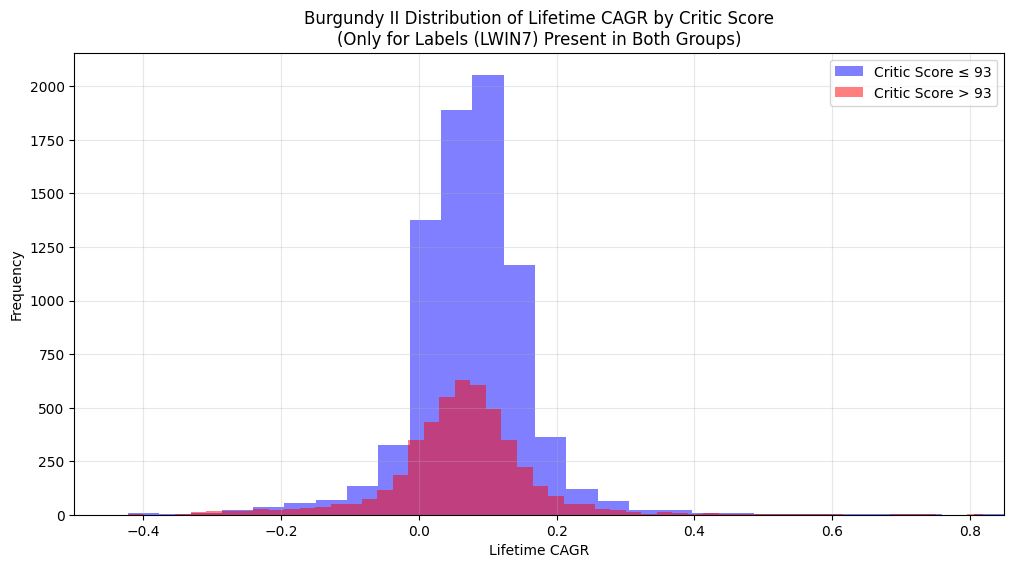

Number of wines present in both groups: 937


In [ ]:
# Create the two groups
low_score_df = df_info_final[df_info_final['mean_critic_score'] <= 93]
high_score_df = df_info_final[df_info_final['mean_critic_score'] > 93]

# Find common lwin7s
common_lwin7s = set(low_score_df['lwin7']).intersection(set(high_score_df['lwin7']))

# Filter both dataframes to only include common lwin7s
low_score_filtered = low_score_df[low_score_df['lwin7'].isin(common_lwin7s)]
high_score_filtered = high_score_df[high_score_df['lwin7'].isin(common_lwin7s)]

# Create the figure and axis
plt.figure(figsize=(12, 6))

# Plot both histograms
plt.hist(low_score_filtered['lifetime_cagr'], 
         bins=100, 
         alpha=0.5, 
         label='Critic Score ≤ 93',
         color='blue')

plt.hist(high_score_filtered['lifetime_cagr'], 
         bins=100, 
         alpha=0.5, 
         label='Critic Score > 93',
         color='red')
plt.xlim(-0.5, 0.85)
# Customize the plot
plt.xlabel('Lifetime CAGR')
plt.ylabel('Frequency')
plt.title(f'{REPORT_NAME} Distribution of Lifetime CAGR by Critic Score\n(Only for Labels (LWIN7) Present in Both Groups)')
plt.legend()
plt.grid(True, alpha=0.3)

# Show the plot
plt.show()

# Print the number of common wines for context
print(f"Number of wines present in both groups: {len(common_lwin7s)}")

In [ ]:
lwins_high = df_info_final[df_info_final['mean_critic_score'] >= 97]['lwin11'].to_list()
lwins_mid = df_info_final[(df_info_final['mean_critic_score'] >= 94) & (df_info_final['mean_critic_score'] <= 96)]['lwin11'].to_list()
lwins_low = df_info_final[(df_info_final['mean_critic_score'] <= 93)]['lwin11'].to_list()
print(len(lwins_high))
print(len(lwins_mid))
print(len(lwins_low))
print(df_info_final['mean_critic_score'].median())

from_date = '2005-01-01'
ew_index_high  = make_equal_weight_index_smoothed_2(df_time.loc[from_date:][lwins_high])
ew_index_mid  = make_equal_weight_index_smoothed_2(df_time.loc[from_date:][lwins_mid])
ew_index_low  = make_equal_weight_index_smoothed_2(df_time.loc[from_date:][lwins_low])

# Combine the DataFrames into a dictionary
returns_dict = {
    'Critic Score 97 or more': ew_index_high['index_value'],
    'Critic Score between 97 and 94': ew_index_mid['index_value'],
    'Critic Score less than 94': ew_index_low['index_value']
}

# Plot using the provided function
plot_indices_plotly(returns_dict, 
                    watermark_path=watermark_path,
                    title=f'{REPORT_NAME} - 20-Year Indices by Critic Score Bracket', 
                    note='Source: Scores from Vinous, Robert Parker, Jancis Robinson with price data from Liv-ex',
                    colours=colours)


430
2956
11543
92.0


In [ ]:
from_date = '2014-12-18'
ew_index_high = make_equal_weight_index_smoothed_2(df_time.loc[from_date:][lwins_high])
ew_index_mid = make_equal_weight_index_smoothed_2(df_time.loc[from_date:][lwins_mid])
ew_index_low = make_equal_weight_index_smoothed_2(df_time.loc[from_date:][lwins_low])

# Combine the DataFrames into a dictionary
returns_dict = {
    'Critic Score 97 or more': ew_index_high['index_value'],
    'Critic Score between 97 and 94': ew_index_mid['index_value'],
    'Critic Score less than 94': ew_index_low['index_value']
}

# Plot using the provided function
plot_indices_plotly(returns_dict, 
                    watermark_path=watermark_path,
                    title=f'{REPORT_NAME} - 10-Year Indices by Critic Score Bracket', 
                    note='Source: Scores from Vinous, Robert Parker, Jancis Robinson with price data from Liv-ex',
                    colours=colours)


## NV vs V 

In [ ]:
# lwins_nv = df_info_final[(df_info_final['vintage'] == 1000)]['lwin11'].to_list()
# lwins_vintaged = df_info_final[(df_info_final['vintage'] != 1000)]['lwin11'].to_list()

# from_date = '2014-12-18'
# ew_returns_nv, ew_index_nv, percentage_growth, active_wines_count  = make_equal_weight_index_smoothed(df_time.loc[from_date:][lwins_nv])
# ew_returns_vintaged, ew_index_vintaged, percentage_growth, active_wines_count  = make_equal_weight_index_smoothed(df_time.loc[from_date:][lwins_vintaged])

# # Combine the DataFrames into a dictionary
# returns_dict = {
#     'Non-vintage': ew_index_nv['index_value'],
#     'Vintage': ew_index_vintaged['index_value']
# }

# # Plot using the provided function
# plot_indices_plotly(returns_dict, title='Champagne - Vintage vs Non-Vintage')

In [ ]:
# # Turn returns dict into a DataFrame with keys as columns names
# returns_df = pd.DataFrame(returns_dict)
# returns_df.reset_index().to_csv('data/25-01-28 Champagne Vintage vs Non Vintage.csv', index=False)

### Drinking windows

In [ ]:
def analyse_drinking_window(df, dw_field='dw_end', cagr_type='7yr_cagr', current_year=2024, title_suffix=''):
    """
    Analyze and visualize CAGR differences based on drinking window expired_status.
    
    Parameters:
    -----------
    df : pandas DataFrame
        The input DataFrame containing wine data
    dw_field : str, optional
        The drinking window field to analyze ('dw_start' or 'dw_end')
    cagr_type : str, optional
        The type of CAGR to analyze ('5yr_cagr', '7yr_cagr', or 'lifetime_cagr')
    current_year : int, optional
        The year to compare against for determining expired_status
    title_suffix : str, optional
        Additional text to add to the plot title
    """
    # Create working copy with non-null drinking window dates
    df_nodwnull = df[df[dw_field].notna()].copy()
    print(f"This should be zero: {df_nodwnull[dw_field].isna().sum()}")
    
    # Create expired_status column based on drinking window field
    if dw_field == 'dw_end':
        df_nodwnull['expired_status'] = df_nodwnull[dw_field] < current_year
        status_label = 'expired'
        x_labels = ['Pre-expiration', 'Post-expiration']
    else:  # dw_start
        df_nodwnull['expired_status'] = df_nodwnull[dw_field] > current_year
        status_label = 'not started'
        x_labels = ['Drinking window started', 'Not yet started']
    
    # Count wines by expired_status
    status_count = df_nodwnull['expired_status'].value_counts()
    print(f"\nWine counts by expired_status:")
    for expired_status, count in status_count.items():
        label = status_label if expired_status else f"not {status_label}"
        print(f"Number of {label} wines: {count}")
    
    # Calculate average CAGR by expired_status
    avg_cagr_status = df_nodwnull[df_nodwnull['expired_status']][cagr_type].mean()
    avg_cagr_non_status = df_nodwnull[~df_nodwnull['expired_status']][cagr_type].mean()
    
    # Create bar chart
    cagr_values = [avg_cagr_non_status, avg_cagr_status]
    
    fig = go.Figure(data=[
        go.Bar(
            x=x_labels,
            y=cagr_values,
            text=[f'{value:.2%}' for value in cagr_values],
            textposition='outside',
            marker_color=colours[:2]
        )
    ])
    
    # Determine CAGR period for title
    cagr_period = {
        '5yr_cagr': '5-year',
        '7yr_cagr': '7-year',
        'lifetime_cagr': 'Lifetime'
    }.get(cagr_type, '')
    
    # Year range for title
    years_back = {
        '5yr_cagr': 5,
        '7yr_cagr': 7,
        'lifetime_cagr': None
    }
    year_range = f"({current_year - years_back[cagr_type]}-{current_year})" if years_back[cagr_type] else ""
    
    # Customize layout
    title = f'Average {cagr_period} CAGR {year_range} by Drinking Window Status{title_suffix}'
    
    fig.update_layout(
        title=title,
        xaxis_title='Wine Status',
        yaxis_title=f'Average {cagr_period} CAGR',
        yaxis_tickformat='.2%',
        yaxis_range=[0, max(cagr_values) * 1.1]
    )
    
    # Show the plot
    fig.show()
    
    # Return the data for further analysis if needed
    return {
        'status_counts': status_count,
        'cagr_values': pd.Series({x_labels[0]: avg_cagr_non_status, 
                                 x_labels[1]: avg_cagr_status})
    }, df_nodwnull

In [ ]:
dw_summary, df_nodwnull = analyse_drinking_window(df_info_final, dw_field='dw_end', cagr_type='7yr_cagr')
print(dw_summary)

This should be zero: 0

Wine counts by expired_status:
Number of not expired wines: 10062
Number of expired wines: 3879


{'status_counts': expired_status
False    10062
True      3879
Name: count, dtype: int64, 'cagr_values': Pre-expiration     0.079482
Post-expiration    0.091942
dtype: float64}


In [ ]:
expired_lwin11 = df_nodwnull[df_nodwnull['expired_status'] == True]['lwin11'].to_list()
non_expired_lwin11 = df_nodwnull[df_nodwnull['expired_status'] == False]['lwin11'].to_list()

In [ ]:
# recent_trade_expired = lx_trades[(lx_trades['lwin11'].isin(expired_lwin11)) & (lx_trades['trade_date'] > str(pd.Timestamp.now().year) + '-01-01')]
# recent_trade_expired

In [ ]:
df_info_final_no_na = df_info_final.dropna(subset='dw_start')
df_info_final_no_na = df_info_final_no_na[df_info_final_no_na['vintage'] != 1000]
df_info_final_no_na['years_to_drink'] = df_info_final_no_na['dw_start'] - df_info_final_no_na['vintage']
df_info_final_no_na['years_to_expire'] = df_info_final_no_na['dw_end'] - df_info_final_no_na['vintage']

df_info_final_no_na[['years_to_drink', 'years_to_expire', 'dw_length']].describe()

years_to_drink  years_to_expire     dw_length
count    13943.000000     13939.000000  13939.000000
mean         5.888116        20.912261     15.025325
std          4.875126         9.876943      8.558343
min        -77.000000         1.000000     -4.000000
25%          3.000000        13.000000      8.000000
50%          5.000000        20.000000     14.000000
75%          6.000000        27.000000     20.000000
max         45.000000        70.000000    132.000000

### Double digit returners comparrision

In [ ]:
# dropcols = ['price_10yr', 'price_7yr', 'price_5yr', '10yr_cagr','7yr_cagr', '5yr_cagr', 'lwin7', 'current_price', 'first_price_date', 'current_prices-depth_date', 'absolute_returns']
df_info_final[df_info_final['lifetime_cagr'] <= 0.10].describe()

vintage  current_price   bottle_qty       wc_price  five_yr_price  \
count  18214.000000   18214.000000  2420.000000    2420.000000   14177.000000   
mean    2007.729000    4671.734655    16.565289    5236.340909    3790.339070   
min     1976.000000     120.000000     0.000000     180.000000      48.000000   
25%     2001.000000     993.250000     6.000000    1200.000000     780.000000   
50%     2010.000000    1800.000000    12.000000    2100.000000    1380.000000   
75%     2017.000000    3790.000000    21.000000    4300.000000    2868.000000   
max     2022.000000  359962.000000   286.000000  264000.000000  369104.000000   
std       11.018307   13335.245539    18.849864   14712.071344   12705.646182   

        two_yr_price   one_yr_price  mean_critic_score  count_critic_scores  \
count   17290.000000   18214.000000       11136.000000         11160.000000   
mean     5572.092308    5186.203964          92.049309             2.375538   
min        74.000000     120.000000          67.000000             0.000000   
25%       996.000000    1032.000000          90.500000             1.000000   
50%      1887.500000    1920.000000          92.000000             2.000000   
75%      4220.000000    4167.000000          93.625000             3.000000   
max    498510.000000  422713.000000         100.000000            12.000000   
std     17800.295346   15091.998537           2.516189             1.382852   

          dw_start  ...      price_7yr      price_5yr    10yr_cagr  \
count  9440.000000  ...    9814.000000   12231.000000  5838.000000   
mean   2016.520233  ...    3496.982033    4082.863073     0.066042   
min    1985.000000  ...     120.000000     120.000000    -0.258667   
25%    2013.000000  ...     780.280702     853.588889     0.036461   
50%    2018.000000  ...    1356.333333    1499.908046     0.067196   
75%    2022.000000  ...    2772.250000    3120.736667     0.093807   
max    2035.000000  ...  195990.000000  363636.121212     0.500274   
std       8.028344  ...   10642.561647   13343.937046     0.046027   

          7yr_cagr      5yr_cagr  label_average_price  producer_average_price  \
count  9814.000000  12231.000000         18214.000000            18214.000000   
mean      0.047081      0.043108          5432.236718             5566.437578   
min      -0.320617     -0.378486           720.333333              722.555556   
25%       0.004920      0.000000          1251.833333             1888.727891   
50%       0.043950      0.034394          2182.700000             2913.503226   
75%       0.080025      0.082461          4302.593750             5005.563193   
max       0.486635      0.631689        337775.558824           211476.153846   
std       0.051099      0.061803         15032.808972            10522.217240   

                age  label_price-age_corr   dw_length  
count  18214.000000          17205.000000  9438.00000  
mean      16.271000              0.034764    15.33683  
min        2.000000             -0.994001     0.00000  
25%        7.000000             -0.324114     9.00000  
50%       14.000000              0.068181    14.00000  
75%       23.000000              0.398095    20.00000  
max       48.000000              0.999644    60.00000  
std       11.018307              0.454993     8.36916  

[8 rows x 27 columns]

### Prices 
- Correlation between price and returns.
- Correlation between label average price and cagr.
- Correlation between producer average price and cagr.

In [ ]:
def create_price_bracket(price):
    if price <= 1200:
        return '1200 and less'
    elif price <= 2400:
        return '1201-2400'
    elif price <= 4800:
        return '2401-4800'
    elif price <= 9600:
        return '4801-9600'
    elif price <= 19200:
        return '9601-19200'
    elif price > 19200:
        return '19201+'
    else:
        return np.nan

# Create new columns for price brackets
df_info_final['price_5yr_bracket'] = df_info_final['price_5yr'].apply(create_price_bracket)
df_info_final['current_price_bracket'] = df_info_final['current_price'].apply(create_price_bracket)
df_info_final['first_price_bracket'] = df_info_final['first_price'].apply(create_price_bracket)

In [ ]:
price_table_sorted, df_with_ratios = WIS_grouped_table(df_info_final, group_min_observations=32, grouping='price_5yr_bracket')
price_table_sorted.drop_duplicates(inplace=True)
price_table_sorted.head(20)

Avg. Lifetime CAGR (%)  Avg. 7yr CAGR (%)  \
price_5yr_bracket                                              
19201+                               12.0               11.0   
9601-19200                           12.0               12.0   
4801-9600                            10.0               10.0   
1201-2400                             7.0                8.0   
2401-4800                             8.0                8.0   
1200 and less                         7.0                7.0   

                   Avg. 5yr CAGR (%)  Std Dev. (%)  Average Price  \
price_5yr_bracket                                                   
19201+                           7.0           8.0        74380.0   
9601-19200                       9.0           9.0        23507.0   
4801-9600                        8.0           8.0        10537.0   
1201-2400                        8.0           7.0         2680.0   
2401-4800                        8.0           7.0         5204.0   
1200 and less                    8.0           7.0         1233.0   

                   Price_5yr_bracket VC Ratio  \
price_5yr_bracket                               
19201+                                   1.73   
9601-19200                               1.44   
4801-9600                                1.28   
1201-2400                                1.17   
2401-4800                                1.21   
1200 and less                            1.02   

                   Price_5yr_bracket Ret-Adj VC Ratio  \
price_5yr_bracket                                       
19201+                                         0.2312   
9601-19200                                     0.1936   
4801-9600                                      0.1323   
1201-2400                                      0.0959   
2401-4800                                      0.1039   
1200 and less                                  0.0772   

                   Price_5yr_bracket Score  lwin11_count  
price_5yr_bracket                                         
19201+                            100.0000          1060  
9601-19200                         83.3333          1040  
4801-9600                          66.6667          2074  
1201-2400                          50.0000          4748  
2401-4800                          33.3333          3129  
1200 and less                      16.6667          6679

In [ ]:
# Run code 
price_table_sorted_2, df_with_ratios = WIS_grouped_table(df_info_final, group_min_observations=32, grouping='first_price_bracket')
price_table_sorted_2.drop_duplicates(inplace=True)
price_table_sorted_2.head(20)

Avg. Lifetime CAGR (%)  Avg. 7yr CAGR (%)  \
first_price_bracket                                              
1200 and less                           9.0                9.0   
1201-2400                               7.0                8.0   
2401-4800                               7.0                8.0   
4801-9600                               7.0                8.0   
9601-19200                              7.0                8.0   
19201+                                  6.0                9.0   

                     Avg. 5yr CAGR (%)  Std Dev. (%)  Average Price  \
first_price_bracket                                                   
1200 and less                      9.0           7.0         2698.0   
1201-2400                          7.0           7.0         6201.0   
2401-4800                          7.0           8.0        12857.0   
4801-9600                          7.0           9.0        20999.0   
9601-19200                         7.0           9.0        44203.0   
19201+                             7.0          10.0       112423.0   

                     First_price_bracket VC Ratio  \
first_price_bracket                                 
1200 and less                                1.24   
1201-2400                                    1.10   
2401-4800                                    1.05   
4801-9600                                    0.96   
9601-19200                                   1.07   
19201+                                       1.02   

                     First_price_bracket Ret-Adj VC Ratio  \
first_price_bracket                                         
1200 and less                                      0.1144   
1201-2400                                          0.0891   
2401-4800                                          0.0897   
4801-9600                                          0.0791   
9601-19200                                         0.1020   
19201+                                             0.1048   

                     First_price_bracket Score  lwin11_count  
first_price_bracket                                           
1200 and less                         100.0000         10362  
1201-2400                              83.3333          4086  
2401-4800                              66.6667          2367  
4801-9600                              50.0000          1143  
9601-19200                             33.3333           471  
19201+                                 16.6667           301

In [ ]:
def plot_cagr_by_price_bracket(df_filtered_old, watermark_path, colours, cagr_col):
    """
    Create a box plot showing CAGR distribution by price bracket.
    
    Args:
        df_filtered_old (pd.DataFrame): Filtered dataframe
        watermark_path (str): Path to watermark image
        custom_colours (dict): Dictionary mapping price brackets to colors
        cagr_col (str): Name of CAGR column to plot
    """

    custom_colours = {
    '1200 and less': colours[0],  # purple
    '1201-2400': colours[1],      # mantis
    '2401-4800': colours[2],      # sunglow
    '4801-9600': colours[3],      # coral
    '9601-19200': colours[4],     # blue
    '19201+': colours[5]        # red
    }   
    # Ensure the dataframe is sorted by price brackets in ascending order
    bracket_order = ['1200 and less', '1201-2400', '2401-4800', '4801-9600', '9601-19200', '19201+']

    df_filtered_old_liq = df_filtered_old[df_filtered_old['bottle_qty'] > 0].copy()

    # Create a Plotly figure
    fig = go.Figure()

    # Add a box plot for each price bracket
    for bracket in bracket_order:
        fig.add_trace(go.Box(
            x=df_filtered_old_liq[df_filtered_old_liq['price_5yr_bracket'] == bracket][cagr_col],
            name=bracket,
            orientation='h',
            marker_color=custom_colours[bracket],
            boxmean=True  # Show mean marker
        ))

    # Customize the layout
    fig.update_layout(
        title=f'Distribution of {cagr_col.replace("_", " ").split(" ")[0].title()} CAGR by Release Price Bracket',
        xaxis_title=f'{cagr_col.replace("_", " ").split(" ")[0].title()} CAGR',
        yaxis_title='Release Price Bracket (12x75cl)',
        plot_bgcolor='white'
    )

    # Set x-axis limits
    fig.update_xaxes(range=[-0.1, 0.4])  # Adjust the range as necessary

    # Add a vertical line at x=0 for reference
    fig.add_shape(type='line',
                  x0=0, y0=-0.5, x1=0, y1=len(bracket_order)-0.5,
                  line=dict(color='red', width=2, dash='dash'))

    # Include watermark
    watermark = Image.open(watermark_path)
    fig.add_layout_image(
        dict(
            source=watermark,
            xref="paper", yref="paper",
            x=0.52, y=0.5,  # Positioning the logo at the center
            xanchor='center', yanchor='middle',
            sizex=0.8, sizey=0.8,  # Adjust the size of the logo
            opacity=0.65,
            layer="above"
        ))

    # Show the plot
    fig.show()

    return df_filtered_old_liq

selected_col = 'lifetime_cagr'

df_info_final_older = df_info_final[df_info_final['years_to_current'] > 2]

df_filtered_old_liq = plot_cagr_by_price_bracket(df_info_final_older[df_info_final_older['bottle_qty'] > 0], watermark_path, colours, selected_col)
df_filtered_old_liq.groupby('first_price_bracket')[selected_col].describe()

count      mean       std       min       25%       50%  \
first_price_bracket                                                             
1200 and less        1402.0  0.091573  0.097851 -0.148901  0.041989  0.079655   
1201-2400             794.0  0.059901  0.091240 -0.257458  0.009689  0.060161   
19201+                 71.0  0.011670  0.120312 -0.275281 -0.045619  0.019359   
2401-4800             514.0  0.046331  0.097943 -0.306329 -0.000592  0.050074   
4801-9600             250.0  0.030843  0.113595 -0.321390 -0.027139  0.040982   
9601-19200            116.0  0.012869  0.140597 -0.332750 -0.060835  0.046867   

                          75%       max  
first_price_bracket                      
1200 and less        0.128793  1.584255  
1201-2400            0.106812  0.713148  
19201+               0.084811  0.297625  
2401-4800            0.100720  0.472545  
4801-9600            0.097266  0.395721  
9601-19200           0.094364  0.448277

In [ ]:
df_filtered_old_liq.groupby('first_price_bracket')[selected_col].describe()

count      mean       std       min       25%       50%  \
first_price_bracket                                                             
1200 and less        1402.0  0.091573  0.097851 -0.148901  0.041989  0.079655   
1201-2400             794.0  0.059901  0.091240 -0.257458  0.009689  0.060161   
19201+                 71.0  0.011670  0.120312 -0.275281 -0.045619  0.019359   
2401-4800             514.0  0.046331  0.097943 -0.306329 -0.000592  0.050074   
4801-9600             250.0  0.030843  0.113595 -0.321390 -0.027139  0.040982   
9601-19200            116.0  0.012869  0.140597 -0.332750 -0.060835  0.046867   

                          75%       max  
first_price_bracket                      
1200 and less        0.128793  1.584255  
1201-2400            0.106812  0.713148  
19201+               0.084811  0.297625  
2401-4800            0.100720  0.472545  
4801-9600            0.097266  0.395721  
9601-19200           0.094364  0.448277

In [ ]:
selected_col = '10yr_cagr'

plot_cagr_by_price_bracket(df_info_final, watermark_path, colours, selected_col)
df_info_final.groupby('first_price_bracket')[selected_col].describe()

count      mean       std       min       25%       50%  \
first_price_bracket                                                             
1200 and less        5807.0  0.100282  0.064949 -0.165738  0.055916  0.094938   
1201-2400            1972.0  0.100397  0.063951 -0.084129  0.056971  0.095822   
19201+                132.0  0.130039  0.101808 -0.258667  0.072940  0.108968   
2401-4800            1076.0  0.108531  0.069542 -0.051540  0.060255  0.103032   
4801-9600             458.0  0.105660  0.068395 -0.121504  0.056016  0.104951   
9601-19200            224.0  0.117115  0.084424 -0.211638  0.069907  0.113869   

                          75%       max  
first_price_bracket                      
1200 and less        0.139413  0.682589  
1201-2400            0.136238  0.467858  
19201+               0.162134  0.500274  
2401-4800            0.147095  0.381713  
4801-9600            0.145573  0.374742  
9601-19200           0.154822  0.471831

### 

In [ ]:
from_date = '2015-03-01'

lwins_bracket_1 = df_info_final[df_info_final['first_price_bracket'] == '1200 and less']['lwin11'].to_list()
lwins_bracket_2 = df_info_final[df_info_final['first_price_bracket'] == '1201-2400']['lwin11'].to_list()
lwins_bracket_3 = df_info_final[df_info_final['first_price_bracket'] == '2401-4800']['lwin11'].to_list()
lwins_bracket_4 = df_info_final[df_info_final['first_price_bracket'] == '4801-9600']['lwin11'].to_list()
lwins_bracket_5 = df_info_final[df_info_final['first_price_bracket'] == '9601-19200']['lwin11'].to_list()
lwins_bracket_6 = df_info_final[df_info_final['first_price_bracket'] == '19201+']['lwin11'].to_list()


ew_index_1  = make_equal_weight_index_smoothed_2(df_time.loc[from_date:][lwins_bracket_1])
ew_index_2  = make_equal_weight_index_smoothed_2(df_time.loc[from_date:][lwins_bracket_2])
ew_index_3  = make_equal_weight_index_smoothed_2(df_time.loc[from_date:][lwins_bracket_3])
ew_index_4  = make_equal_weight_index_smoothed_2(df_time.loc[from_date:][lwins_bracket_4])
ew_index_5  = make_equal_weight_index_smoothed_2(df_time.loc[from_date:][lwins_bracket_5])
ew_index_6  = make_equal_weight_index_smoothed_2(df_time.loc[from_date:][lwins_bracket_6])


# Combine the DataFrames into a dictionary
returns_dict = {
    '1200 and less': ew_index_1['index_value'],
    '1201-2400': ew_index_2['index_value'],
    '2401-4800': ew_index_3['index_value'],
    '4801-9600': ew_index_4['index_value'],
    '9601-19200': ew_index_5['index_value'],
    '19201+': ew_index_6['index_value']
}

# Plot using the provided function
plot_indices_plotly(returns_dict, 
                    watermark_path=watermark_path,
                    title=f'{REPORT_NAME} - 10-Year Indices by Release Price Bracket', 
                    note='     Source: prices based on Liv-ex market price data, 12x75cl case normalised best list prices.',
                    colours=colours)


In [ ]:
from_date = '2005-03-01'

lwins_bracket_1 = df_info_final[df_info_final['first_price_bracket'] == '1200 and less']['lwin11'].to_list()
lwins_bracket_2 = df_info_final[df_info_final['first_price_bracket'] == '1201-2400']['lwin11'].to_list()
lwins_bracket_3 = df_info_final[df_info_final['first_price_bracket'] == '2401-4800']['lwin11'].to_list()
lwins_bracket_4 = df_info_final[df_info_final['first_price_bracket'] == '4801-9600']['lwin11'].to_list()
lwins_bracket_5 = df_info_final[df_info_final['first_price_bracket'] == '9601-19200']['lwin11'].to_list()
# lwins_bracket_6 = df_info_final[df_info_final['first_price_bracket'] == '19201+']['lwin11'].to_list()


ew_index_1  = make_equal_weight_index_smoothed_2(df_time.loc[from_date:][lwins_bracket_1])
ew_index_2  = make_equal_weight_index_smoothed_2(df_time.loc[from_date:][lwins_bracket_2])
ew_index_3  = make_equal_weight_index_smoothed_2(df_time.loc[from_date:][lwins_bracket_3])
ew_index_4  = make_equal_weight_index_smoothed_2(df_time.loc[from_date:][lwins_bracket_4])
ew_index_5  = make_equal_weight_index_smoothed_2(df_time.loc[from_date:][lwins_bracket_5])
# ew_index_6  = make_equal_weight_index_smoothed_2(df_time.loc[from_date:][lwins_bracket_6])


# Combine the DataFrames into a dictionary
returns_dict = {
    '1200 and less': ew_index_1['index_value'],
    '1201-2400': ew_index_2['index_value'],
    '2401-4800': ew_index_3['index_value'],
    '4801-9600': ew_index_4['index_value'],
    '9601-19200': ew_index_5['index_value'],
    # '19201+': ew_index_6['index_value']
}

# Plot using the provided function
plot_indices_plotly(returns_dict, 
                    watermark_path=watermark_path,
                    title=f'{REPORT_NAME} - 20-Year Indices by Release Price Bracket', 
                    note='     Source: prices based on Liv-ex market price data, 12x75cl case normalised best list prices.',
                    colours=colours)


In [ ]:
colours

['#7c60f9',
 '#83D483',
 '#FFD166',
 '#F78C6B',
 '#4D87D0',
 '#EF476F',
 '#06D6A0',
 '#C23FB7']

In [ ]:
colours_limited = ['#83D483', '#EF476F']

from_date = '2005-03-01'

lwins_bracket_1 = df_info_final[df_info_final['first_price_bracket'].isin(['1200 and less','1201-2400', '2401-4800', '4801-9600'])]['lwin11'].to_list()
lwins_bracket_5 = df_info_final[df_info_final['first_price_bracket'].isin(['9601-19200', '19201+'])]['lwin11'].to_list()

ew_index_1  = make_equal_weight_index_smoothed_2(df_time.loc[from_date:][lwins_bracket_1])
ew_index_5  = make_equal_weight_index_smoothed_2(df_time.loc[from_date:][lwins_bracket_5])


# Combine the DataFrames into a dictionary
returns_dict = {
    '1200-9600': ew_index_1['index_value'],
    '9601+': ew_index_5['index_value'],
}

# Plot using the provided function
plot_indices_plotly(returns_dict, 
                    watermark_path=watermark_path,
                    title=f'{REPORT_NAME} - 20-Year Indices by Release Price Bracket', 
                    note='     Source: prices based on Liv-ex market price data, 12x75cl case normalised best list prices.',
                    colours=colours_limited)


# Purchase & Exit Timing

**CAGR Arcs:**

In [ ]:
df_enough_prices = df_info_final[(df_info_final['years_to_current'] > 1.5) & (df_info_final['vintage'] != 1000)].copy()

colours_3 = ['#83D483', '#F78C6B', '#FFD166']
# Prepare the data
cagr_metrics = ['5yr_cagr', '7yr_cagr', 'lifetime_cagr']
vintage_cagr = df_enough_prices.groupby('vintage')[cagr_metrics].mean().reset_index()
vintage_cagr = vintage_cagr[vintage_cagr['vintage'] <= 2019].sort_values('vintage')

# Create the Plotly figure
fig = go.Figure()

# Add a trace for each CAGR metric
for i, metric in enumerate(cagr_metrics):
    fig.add_trace(go.Scatter(
        x=vintage_cagr['vintage'],
        y=vintage_cagr[metric],
        mode='lines+markers',
        name=f'Average {metric.replace("_", " ").title()}',
        line=dict(color=colours_3[i % len(colours_3)], width=2),
        marker=dict(size=6)
    ))

# Customize the layout
fig.update_layout(
    title='Average CAGR Metrics by Vintage',
    xaxis_title='Vintage',
    yaxis_title='Average CAGR',
    yaxis_tickformat='.2%',  # Format y-axis as percentage
    hovermode='x unified',
    template='plotly_white',  # Use a white background template
    legend=dict(
        orientation="h",
        yanchor="bottom",
        y=1.02,
        xanchor="right",
        x=1
    )
)

# Show the plot
fig.show()

# Labels

In [ ]:
# Run code 
print('Total number of names', df_info_final['name'].nunique())
labs_table_sorted, df_with_ratios = WIS_grouped_table(df_info_final[df_info_final['vintage'] != 1000], group_min_observations=4, grouping='name', liquidity_influence=0.3)
find_top_labels = pd.merge(labs_table_sorted.reset_index(), df_info[['region','name','producer', 'lwin7']], on='name', how='left')
find_top_labels.rename(columns={'region' : 'Region', 'name': 'name'}, inplace=True)
find_top_labels.drop_duplicates(inplace=True)
find_top_labels.dropna().head()

Total number of names 2578


name  Avg. Lifetime CAGR (%)  \
0              Vincent Dancer, Meursault, Les Corbins                    24.0   
7   Domaine Paul Pillot, Chassagne-Montrachet Prem...                    19.0   
19  Domaine d'Auvenay, Bourgogne Aligote, Sous Cha...                    40.0   
41  Domaine Paul Pillot, Chassagne-Montrachet Prem...                    22.0   
54  Domaine Leroy, Vosne-Romanee Premier Cru, Les ...                    16.0   

    Avg. 7yr CAGR (%)  Avg. 5yr CAGR (%)  Std Dev. (%)  Average Price  \
0                24.0               19.0           1.0         1944.0   
7                23.0               28.0           1.0         1940.0   
19               44.0               41.0           7.0        40696.0   
41               24.0               26.0           3.0         3926.0   
54               17.0               14.0           3.0        38552.0   

    Label VC Ratio  Label Ret-Adj VC Ratio  Label Score  lwin11_count  \
0            18.47                  4.3849     100.0000             4   
7            16.68                  3.5421      99.9217             7   
19            5.43                  2.1729      99.8434            13   
41            7.80                  1.8258      99.7651             9   
54            6.16                  1.1820      99.6868            26   

      Region             producer    lwin7  
0   Burgundy       Vincent Dancer  1066377  
7   Burgundy  Domaine Paul Pillot  1078086  
19  Burgundy    Domaine d'Auvenay  1317017  
41  Burgundy  Domaine Paul Pillot  1078060  
54  Burgundy        Domaine Leroy  1044676

### Make an index for each label

- Which labels have fallen the most since the market peak

In [ ]:
# Group the data by wine label and create an index for each
label_indices = {}

# Get unique wine labels
unique_labels = df_info_final['name'].unique()

# Create an index for each label
for label in unique_labels:
    # Filter data for this label
    label_lwins = df_info_final[df_info_final['name'] == label]['lwin11'].to_list()
    
    # Check if we have enough data for this label
    if len(label_lwins) > 10:  # Adjust this threshold as needed
        df_time_label = df_time.loc[from_date:][label_lwins]
        try:
            # Create an equal-weight index for this label
            ew_index_1 = make_equal_weight_index_smoothed_2(df_time_label)

            ew_returns = ew_index_1['raw_return']
            
            # Store the index if it was successfully created
            if ew_returns is not None and not ew_index_1.empty:
                label_indices[label] = ew_index_1
        except Exception as e:
            print(f"Error creating index for {label}: {e}")

# Find which labels have fallen in price the most since 2022-09-30
reference_date = '2022-09-30'
price_changes = []

for label, index_df in label_indices.items():
    # Make sure the index includes our reference date
    if reference_date in index_df.index:
        # Get the reference price
        reference_price = index_df.loc[reference_date, 'index_value']
        
        # Get the latest price
        latest_date = index_df.index.max()
        latest_price = index_df.loc[latest_date, 'index_value']
        
        # Calculate percentage change
        percent_change = (latest_price - reference_price) / reference_price * 100
        
        # Add to our list
        price_changes.append({
            'label': label,
            'reference_price': reference_price,
            'latest_price': latest_price,
            'latest_date': latest_date,
            'percent_change': percent_change
        })

# Convert to DataFrame and sort by percent change (ascending to get biggest drops first)
price_changes_df = pd.DataFrame(price_changes)
price_changes_df = price_changes_df.sort_values('percent_change', ascending=True)
price_changes_df.head(20)

label  reference_price  \
455          Domaine d'Auvenay, Meursault, Les Narvaux      6688.897681   
298  Domaine Leroy, Vosne-Romanee Premier Cru, Les ...      3318.461583   
791  Domaine d'Auvenay, Bourgogne Aligote, Sous Cha...     13953.687792   
26   Domaine Arnoux-Lachaux, Romanee-Saint-Vivant G...       912.515608   
413  Domaine Georges Roumier, Chambolle-Musigny Pre...      3247.035564   
33           Domaine d'Auvenay, Bonnes Mares Grand Cru      2412.429684   
122  Domaine de la Romanee-Conti, Romanee-Saint-Viv...      1427.229471   
702  Domaine de la Romanee-Conti, Corton Grand Cru,...       569.336907   
415  Domaine Georges Roumier, Chambolle-Musigny Pre...      1904.416444   
121  Domaine de la Romanee-Conti, Romanee-Conti Gra...      1084.191393   
163      Domaine Rene Engel, Clos de Vougeot Grand Cru      1022.068218   
23   Domaine Arnoux-Lachaux, Nuits-Saint-Georges, R...       695.373359   
296      Domaine Leroy, Romanee-Saint-Vivant Grand Cru      2423.341021   
69   Domaine Sylvain Cathiard, Nuits-Saint-Georges ...       453.739953   
411          Domaine Georges Roumier, Bourgogne, Rouge       742.504508   
496           Coche-Dury, Corton-Charlemagne Grand Cru       925.400709   
532  Vincent Dancer, Meursault Premier Cru, Perrier...       611.385801   
187  Domaine Fourrier, Morey-Saint-Denis, Clos Solo...       193.117730   
186  Domaine Fourrier, Gevrey-Chambertin, Vieille V...       258.550681   
410    Domaine Georges Roumier, Bonnes Mares Grand Cru      2513.503434   

     latest_price latest_date  percent_change  
455   4949.553330  2025-06-30      -26.003453  
298   2589.113057  2025-06-30      -21.978513  
791  11062.014085  2025-06-30      -20.723365  
26     724.498199  2025-06-30      -20.604295  
413   2580.319909  2025-06-30      -20.533057  
33    1929.830562  2025-06-30      -20.004692  
122   1143.790829  2025-06-30      -19.859360  
702    456.702172  2025-06-30      -19.783494  
415   1535.969897  2025-06-30      -19.346953  
121    874.531762  2025-06-30      -19.337880  
163    824.715400  2025-06-30      -19.309163  
23     561.450308  2025-06-30      -19.259158  
296   1961.183469  2025-06-30      -19.071090  
69     368.812107  2025-06-30      -18.717295  
411    603.917161  2025-06-30      -18.664849  
496    755.870074  2025-06-30      -18.319700  
532    499.468437  2025-06-30      -18.305522  
187    158.087342  2025-06-30      -18.139395  
186    211.951683  2025-06-30      -18.023158  
410   2068.906693  2025-06-30      -17.688328

In [ ]:
price_changes_df['label'].to_list()[:30]

["Domaine d'Auvenay, Meursault, Les Narvaux",
 'Domaine Leroy, Vosne-Romanee Premier Cru, Les Beaux Monts',
 "Domaine d'Auvenay, Bourgogne Aligote, Sous Chatelet",
 'Domaine Arnoux-Lachaux, Romanee-Saint-Vivant Grand Cru',
 'Domaine Georges Roumier, Chambolle-Musigny Premier Cru, Les Amoureuses',
 "Domaine d'Auvenay, Bonnes Mares Grand Cru",
 'Domaine de la Romanee-Conti, Romanee-Saint-Vivant Grand Cru, Marey-Monge',
 'Domaine de la Romanee-Conti, Corton Grand Cru, Prince Florent de Merode',
 'Domaine Georges Roumier, Chambolle-Musigny Premier Cru, Les Cras',
 'Domaine de la Romanee-Conti, Romanee-Conti Grand Cru',
 'Domaine Rene Engel, Clos de Vougeot Grand Cru',
 'Domaine Arnoux-Lachaux, Nuits-Saint-Georges, Rouge',
 'Domaine Leroy, Romanee-Saint-Vivant Grand Cru',
 'Domaine Sylvain Cathiard, Nuits-Saint-Georges Premier Cru, Aux Thorey',
 'Domaine Georges Roumier, Bourgogne, Rouge',
 'Coche-Dury, Corton-Charlemagne Grand Cru',
 'Vincent Dancer, Meursault Premier Cru, Perrieres Blanc'

In [ ]:
# check_trades = ['1030875', '1064706', '1057005', '1030875', '1044432', '1028687']
# check_trades = ['1056789']
# lx_trades[(lx_trades['lwin7'].isin(check_trades)) & (lx_trades['trade_date'] > '2024-11-30')]

In [ ]:
select_labels = [
    # 'Domaine Georges Roumier, Chambolle-Musigny Premier Cru, Les Amoureuses',
                # "Domaine d'Auvenay, Bourgogne Aligote, Sous Chatelet",
                # 'Domaine Rene Engel, Clos de Vougeot Grand Cru',
                'Domaine Armand Rousseau, Chambertin Grand Cru',
                'Domaine de la Romanee-Conti, Romanee-Conti Grand Cru',
                # 'Domaine Leroy, Vosne-Romanee Premier Cru, Les Beaux Monts',
                # "Domaine d'Auvenay, Meursault, Les Narvaux",
                # 'Domaine de la Romanee-Conti, Corton Grand Cru, Prince Florent de Merode',
                'Domaine Georges Roumier, Bonnes Mares Grand Cru',
                'Coche-Dury, Corton-Charlemagne Grand Cru',
                # 'Emmanuel Rouget, Vosne-Romanee Premier Cru, Cros Parantoux',
                "Domaine d'Auvenay, Bonnes Mares Grand Cru",
                # 'Domaine Bizot, Echezeaux Grand Cru',
                # 'Domaine de la Romanee-Conti, Romanee-Saint-Vivant Grand Cru, Marey-Monge',
                # 'Domaine Sylvain Cathiard, Nuits-Saint-Georges Premier Cru, Aux Thorey',
                # 'Domaine Georges Roumier, Chambolle-Musigny Premier Cru, Les Cras',
                # 'Domaine de Montille, Vosne-Romanee Premier Cru, Aux Malconsorts',
                # 'Domaine Rene Engel, Grands Echezeaux Grand Cru',
                # 'Domaine Georges Roumier, Bourgogne, Rouge',
                'Domaine Arnoux-Lachaux, Romanee-Saint-Vivant Grand Cru'
                 ]

# select_labels = price_changes_df['label'].to_list()[:30]

label_note = 'Source: prices based on Liv-ex market price data, 12x75cl case normalised best list prices. Including vintages from 1975 onwards.'
from_date = '2006-01-01'
for label in select_labels:
    label_lwins = df_info_final[df_info_final['name'] == label]['lwin11'].to_list()
    label_lwin7 = df_info_final[df_info_final['name'] == label]['lwin7'].unique()
    print(label_lwin7)
    df_time_label = df_time.loc[from_date:][label_lwins]
    ew_index_1= make_equal_weight_index_smoothed_2(df_time_label)
    # plot_index_enhanced(ew_returns, watermark_path, main_purple)
    plot_index_enhanced(ew_index_1['index_value'], 
                    watermark_path, 
                    main_purple,
                    title=f'{REPORT_NAME} - {label.split(",")[0]}, Equal Weighted Index', 
                    height=700, 
                    note=label_note)

['1057005']


['1028687']


['1056789']


['1064706']


['1019197']


['1018783']


### Top performing labels

In [ ]:
top_names = find_top_labels[find_top_labels['lwin11_count'] > 10].dropna().head(20)['name'].values
top_names 

array(["Domaine d'Auvenay, Bourgogne Aligote, Sous Chatelet",
       'Domaine Leroy, Vosne-Romanee Premier Cru, Les Beaux Monts',
       'Domaine Bizot, Echezeaux Grand Cru',
       'Domaine Leroy, Nuits-Saint-Georges, Aux Allots',
       'Domaine Leroy, Vosne-Romanee, Aux Genaivrieres',
       "Domaine d'Auvenay, Puligny-Montrachet Premier Cru, Les Folatieres",
       'Hubert Lamy, Saint-Aubin Premier Cru, En Remilly Blanc',
       'Domaine Leroy, Corton Grand Cru, Les Renardes',
       "Domaine d'Auvenay, Chevalier-Montrachet Grand Cru",
       'Domaine Arnoux-Lachaux, Vosne-Romanee',
       'Domaine Leflaive, Montrachet Grand Cru',
       'Domaine Francois Raveneau, Chablis Premier Cru, Montmains',
       'Domaine Rene Engel, Clos de Vougeot Grand Cru',
       'Pierre-Yves Colin-Morey, Meursault Premier Cru, Perrieres',
       'Domaine Leroy, Nuits-Saint-Georges Premier Cru, Aux Boudots',
       'Domaine de la Romanee-Conti, Echezeaux Grand Cru',
       'Domaine de la Romanee-Conti,

In [ ]:
select_top_names = [
    #    'Domaine Leroy, Vosne-Romanee Premier Cru, Les Beaux Monts',
    #    "Domaine d'Auvenay, Puligny-Montrachet Premier Cru, Les Folatieres",
       'Hubert Lamy, Saint-Aubin Premier Cru, En Remilly Blanc',
       'Domaine Francois Raveneau, Chablis Premier Cru, Forets',
       'Domaine Rene Engel, Clos de Vougeot Grand Cru',
       'Domaine de la Romanee-Conti, Echezeaux Grand Cru',
       'Domaine Leflaive, Chevalier-Montrachet Grand Cru',
    #    "Domaine d'Auvenay, Chevalier-Montrachet Grand Cru",
    #    'Jacques-Frederic Mugnier, Nuits-Saint-Georges Premier Cru, Clos de la Marechale Rouge',
       'Domaine Leflaive, Montrachet Grand Cru',
       'Domaine Leroy, Corton Grand Cru, Les Renardes',
       'Prieure Roch, Nuits-Saint-Georges Premier Cru, Vieilles Vignes',
       'Domaine Leroy, Nuits-Saint-Georges Premier Cru, Aux Boudots',
       ]
label_indices_top = {name: label_indices[name] for name in select_top_names if name in label_indices}
label_indices_top

{'Hubert Lamy, Saint-Aubin Premier Cru, En Remilly Blanc':             raw_return  smoothed_return  index_value  qty_active_wines  \
 date                                                                     
 2005-03-31         NaN              NaN   100.000000                 0   
 2005-04-30         NaN              NaN   100.000000                 0   
 2005-05-31         NaN              NaN   100.000000                 0   
 2005-06-30         NaN              NaN   100.000000                 0   
 2005-07-31         NaN              NaN   100.000000                 0   
 ...                ...              ...          ...               ...   
 2025-02-28   -0.006784        -0.009675   510.004162                19   
 2025-03-31    0.004880        -0.006427   506.726129                19   
 2025-04-30    0.014423         0.004173   508.840578                19   
 2025-05-31   -0.003139         0.005388   511.582092                19   
 2025-06-30   -0.005406         0.001959  

In [ ]:
# First, drop rows with null index_values for all labels
for label in label_indices_top.keys():
    label_indices_top[label] = label_indices_top[label].dropna(subset=['index_value'])

# Find the maximum date across all labels
max_date_overall = max(label_indices_top[label].index.max() for label in label_indices_top.keys())

# Filter out labels that don't have the maximum date
labels_to_remove = []
for label in label_indices_top.keys():
    index_data = label_indices_top[label].index
    max_date = index_data.max()
    print(f"{label}:")
    print(f"  Min date: {index_data.min()}")
    print(f"  Max date: {max_date}")
    
    if max_date != max_date_overall:
        labels_to_remove.append(label)
        print(f"  ** Will be removed (max date {max_date} != overall max {max_date_overall})")
    print()

# Remove labels that don't have the maximum date
for label in labels_to_remove:
    del label_indices_top[label]

print(f"Removed {len(labels_to_remove)} labels that don't have max date {max_date_overall}")
print(f"Remaining labels: {list(label_indices_top.keys())}")

Hubert Lamy, Saint-Aubin Premier Cru, En Remilly Blanc:
  Min date: 2005-03-31 00:00:00
  Max date: 2025-06-30 00:00:00

Domaine Francois Raveneau, Chablis Premier Cru, Forets:
  Min date: 2005-03-31 00:00:00
  Max date: 2025-06-30 00:00:00

Domaine Rene Engel, Clos de Vougeot Grand Cru:
  Min date: 2005-03-31 00:00:00
  Max date: 2025-06-30 00:00:00

Domaine de la Romanee-Conti, Echezeaux Grand Cru:
  Min date: 2005-03-31 00:00:00
  Max date: 2025-06-30 00:00:00

Domaine Leflaive, Chevalier-Montrachet Grand Cru:
  Min date: 2005-03-31 00:00:00
  Max date: 2025-06-30 00:00:00

Domaine Leflaive, Montrachet Grand Cru:
  Min date: 2005-03-31 00:00:00
  Max date: 2025-06-30 00:00:00

Domaine Leroy, Corton Grand Cru, Les Renardes:
  Min date: 2005-03-31 00:00:00
  Max date: 2025-06-30 00:00:00

Prieure Roch, Nuits-Saint-Georges Premier Cru, Vieilles Vignes:
  Min date: 2005-03-31 00:00:00
  Max date: 2025-06-30 00:00:00

Domaine Leroy, Nuits-Saint-Georges Premier Cru, Aux Boudots:
  Min dat

In [ ]:
plot_indices_plotly(label_indices_top, 
                    watermark_path=watermark_path, 
                    title=f'{REPORT_NAME} - Select Label Equal Weighted Indices', 
                    note='Source: prices based on Liv-ex market price data, 12x75cl case normalised best list prices.', 
                    colours=colours, 
                    height=600)

In [ ]:
# find_top_labels.to_csv('data/24-11-17_nv_champagne.csv', index=False)